In this file I compute SHAP explanations and produce global maps of Pb concentration using the best model identified in 'Pb-67_model-selection.ipynb'.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
import shap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


##### Get same train-test split as in model-selection file

In [2]:
with open('../../Data/WOD_Pb_dataset-cleanedSOPbconc.csv', mode='r', newline='') as csvfile:
    WOD_pb_dataset = pd.read_csv(csvfile)
WOD_pb_dataset

Cruise  WOD_depth  WOD_latitude [degrees_north]  \
0              GA01         15                          40.5   
1              GA01         25                          40.5   
2              GA01         55                          40.5   
3              GA01        200                          40.5   
4              GA01        500                          40.5   
...             ...        ...                           ...   
9940  GP06-Chen2023        200                          29.5   
9941  GP06-Chen2023        300                          29.5   
9942  GP06-Chen2023        150                          29.5   
9943  GP06-Chen2023        500                          29.5   
9944  GP06-Chen2023         40                          29.5   

      WOD_longitude [degrees_east]  Pb_CONC [pmol/kg]  Pb_206_207  Pb_208_207  \
0                            -12.5          30.100000      1.1798      2.4483   
1                            -12.5          28.500000      1.1771      2.4479   
2                            -12.5          27.299999      1.1781      2.4495   
3                            -12.5          32.000000      1.1871      2.4515   
4                            -12.5          34.799999      1.1789      2.4514   
...                            ...                ...         ...         ...   
9940                         130.5          53.977687      1.1648      2.4493   
9941                         130.5          56.898171      1.1641      2.4493   
9942                         130.5          45.360875         NaN         NaN   
9943                         130.5          39.556952         NaN         NaN   
9944                         130.5          40.600803         NaN         NaN   

     Ocean_basin  Salinity  Temperature  ...  Nitrate  Phosphate   Oxygen  \
0       Atlantic    35.985       17.068  ...    0.990      0.125  246.679   
1       Atlantic    35.984       16.883  ...    1.087      0.130  247.044   
2       Atlantic    35.965       15.424  ...    1.952      0.165  246.471   
3       Atlantic    35.799       13.013  ...    7.936      0.456  230.087   
4       Atlantic    35.634       11.463  ...   13.444      0.781  207.979   
...          ...       ...          ...  ...      ...        ...      ...   
9940     Pacific    34.725       18.135  ...    4.981      0.411  191.026   
9941     Pacific    34.618       15.491  ...    8.925      0.719  178.790   
9942     Pacific    34.752       19.751  ...    2.939      0.287  197.577   
9943     Pacific    34.361       10.335  ...   20.145      1.467  145.696   
9944     Pacific    34.588       23.882  ...    0.377      0.105  211.573   

          AOU     MLD   Sigma  Chlorophyll-a  Black Carbon AOD  Dust AOD  \
0      -5.164  86.271  26.381       0.161568          0.005372  0.012002   
1      -4.812  86.271  26.476       0.161568          0.005372  0.012002   
2      -0.496  86.271  26.906       0.161568          0.005372  0.012002   
3      28.816  86.271  27.933       0.161568          0.005372  0.012002   
4      59.479  86.271  29.467       0.161568          0.005372  0.012002   
...       ...     ...     ...            ...               ...       ...   
9940   43.117  62.998  25.955       0.298270          0.011949  0.018216   
9941   67.295  62.998  26.933       0.298270          0.011949  0.018216   
9942   30.128  62.998  25.364       0.298270          0.011949  0.018216   
9943  126.283  62.998  28.667       0.298270          0.011949  0.018216   
9944    0.994  62.998  23.644       0.298270          0.011949  0.018216   

      Bottom_distance  
0              5243.0  
1              5233.0  
2              5203.0  
3              5058.0  
4              4758.0  
...               ...  
9940           2867.0  
9941           2767.0  
9942           2917.0  
9943           2567.0  
9944           3027.0  

[9945 rows x 21 columns]

In [3]:
pb_67_dataset = WOD_pb_dataset.dropna(subset = ['Pb_206_207'])
len(pb_67_dataset)

2014

In [4]:
pb_67_dataset_ref = pb_67_dataset.copy()

In [5]:
pb_67_dataset.drop(['Ocean_basin'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
idx_1 = pb_67_dataset[(pb_67_dataset['Cruise'] == 'GA02') & (pb_67_dataset['WOD_latitude [degrees_north]'] < 0) & (pb_67_dataset['WOD_latitude [degrees_north]'] > -27)].index

test_geo_NA = pb_67_dataset.loc[idx_1]
#test_geo_NA

In [7]:
dataset = pb_67_dataset.drop(idx_1)
#dataset

In [8]:
y_test_geo_NA = test_geo_NA['Pb_206_207']
X_test_geo_NA = test_geo_NA.drop(['Pb_CONC [pmol/kg]', 'Pb_206_207', 'Pb_208_207', 'Cruise', 'WOD_latitude [degrees_north]', 'WOD_longitude [degrees_east]'], axis=1)

In [9]:
y = dataset['Pb_206_207']
X = dataset.drop(['Pb_CONC [pmol/kg]', 'Pb_206_207', 'Pb_208_207', 'Cruise', 'WOD_latitude [degrees_north]', 'WOD_longitude [degrees_east]'], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)
#print((len(X_test) + len(X_test_geo_NA))/len(pb_67_dataset))

### <strong style = "color:cyan"> XGBoost - model analysis </strong>

In [12]:
model_grid = pd.read_csv('Model_output/XGBoost-GridsearchCV_67pb_results_20240924-111640_with-test-performance.csv')
model_grid.sort_values(by='rank_test_score', inplace=True)
model_grid

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3517       3.975146      0.405896         0.039964        0.006697   
3529       4.307077      0.552135         0.037635        0.002588   
3505       3.820993      0.382488         0.036165        0.003757   
3528       4.205646      0.419087         0.038136        0.003650   
3516       4.158430      0.376955         0.036450        0.006132   
...             ...           ...              ...             ...   
5015       0.369199      0.004469         0.006308        0.000373   
5003       0.352656      0.006535         0.005801        0.000285   
4991       0.336275      0.026151         0.005736        0.000224   
5039       0.444544      0.020473         0.006571        0.000604   
5027       0.416148      0.012050         0.006528        0.001140   

      param_colsample_bytree  param_learning_rate  param_max_depth  \
3517                     0.7                 0.01                8   
3529                     0.7                 0.01                8   
3505                     0.7                 0.01                8   
3528                     0.7                 0.01                8   
3516                     0.7                 0.01                8   
...                      ...                  ...              ...   
5015                     0.7                 0.10                4   
5003                     0.7                 0.10                4   
4991                     0.7                 0.10                4   
5039                     0.7                 0.10                4   
5027                     0.7                 0.10                4   

      param_min_child_weight  param_n_estimators  param_reg_alpha  ...  \
3517                      10                1400              0.0  ...   
3529                      10                1500              0.0  ...   
3505                      10                1300              0.0  ...   
3528                      10                1500              0.0  ...   
3516                      10                1400              0.0  ...   
...                      ...                 ...              ...  ...   
5015                      12                1300              1.0  ...   
5003                      12                1200              1.0  ...   
4991                      12                1100              1.0  ...   
5039                      12                1500              1.0  ...   
5027                      12                1400              1.0  ...   

      split2_test_score split3_test_score  split4_test_score  mean_test_score  \
3517          -0.000052         -0.000044          -0.000036        -0.000038   
3529          -0.000052         -0.000044          -0.000036        -0.000038   
3505          -0.000052         -0.000044          -0.000036        -0.000038   
3528          -0.000053         -0.000043          -0.000037        -0.000038   
3516          -0.000053         -0.000043          -0.000037        -0.000038   
...                 ...               ...                ...              ...   
5015          -0.000131         -0.000130          -0.000109        -0.000116   
5003          -0.000131         -0.000130          -0.000109        -0.000116   
4991          -0.000131         -0.000130          -0.000109        -0.000116   
5039          -0.000131         -0.000130          -0.000109        -0.000116   
5027          -0.000131         -0.000130          -0.000109        -0.000116   

      std_test_score  rank_test_score  rmse_test  mape_test  rmse_test_geo_NA  \
3517        0.000010                1   0.005623   0.002780          0.004585   
3529        0.000010                2   0.005623   0.002780          0.004585   
3505        0.000010                3   0.005623   0.002780          0.004585   
3528        0.000010                4   0.005563   0.002703          0.004493   
3516        0.000010                5   0.005563   0.0027

In [13]:
best_xgb_model = XGBRegressor(colsample_bytree=model_grid['param_colsample_bytree'].to_numpy()[0], 
                              learning_rate=model_grid['param_learning_rate'].to_numpy()[0], 
                              max_depth=model_grid['param_max_depth'].to_numpy()[0], 
                              min_child_weight=model_grid['param_min_child_weight'].to_numpy()[0], 
                              n_estimators=model_grid['param_n_estimators'].to_numpy()[0], 
                              reg_alpha=model_grid['param_reg_alpha'].to_numpy()[0],
                              reg_lambda=model_grid['param_reg_lambda'].to_numpy()[0],
                              early_stopping_rounds=50,
                              eval_metric = 'rmse',
                              seed=42)

best_xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[0]	validation_0-rmse:0.01281	validation_1-rmse:0.01243
[1]	validation_0-rmse:0.01271	validation_1-rmse:0.01235
[2]	validation_0-rmse:0.01261	validation_1-rmse:0.01226
[3]	validation_0-rmse:0.01252	validation_1-rmse:0.01218
[4]	validation_0-rmse:0.01243	validation_1-rmse:0.01211
[5]	validation_0-rmse:0.01234	validation_1-rmse:0.01202
[6]	validation_0-rmse:0.01225	validation_1-rmse:0.01194
[7]	validation_0-rmse:0.01216	validation_1-rmse:0.01187
[8]	validation_0-rmse:0.01207	validation_1-rmse:0.01179
[9]	validation_0-rmse:0.01198	validation_1-rmse:0.01172
[10]	validation_0-rmse:0.01190	validation_1-rmse:0.01165
[11]	validation_0-rmse:0.01181	validation_1-rmse:0.01158
[12]	validation_0-rmse:0.01172	validation_1-rmse:0.01151
[13]	validation_0-rmse:0.01164	validation_1-rmse:0.01144
[14]	validation_0-rmse:0.01155	validation_1-rmse:0.01137
[15]	validation_0-rmse:0.01147	validation_1-rmse:0.01130
[16]	validation_0-rmse:0.01139	validation_1-rmse:0.01123
[17]	validation_0-rmse:0.01131	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
y_pred = best_xgb_model.predict(X_test, iteration_range=(0, best_xgb_model.best_iteration + 1))
y_pred_geo_NA = best_xgb_model.predict(X_test_geo_NA, iteration_range=(0, best_xgb_model.best_iteration + 1))

In [15]:
test_set_with_pred = X_test.copy()
test_set_with_pred['y_test'] = y_test
test_set_with_pred['y_pred'] = y_pred

In [16]:
merged_df = pd.merge(test_set_with_pred, pb_67_dataset_ref, left_index=True, right_index=True)

In [17]:
merged_test_set = pd.merge(test_set_with_pred, pb_67_dataset_ref, left_index=True, right_index=True)
merged_test_set

WOD_depth_x  Salinity_x  Temperature_x  Silicate_x  Nitrate_x  \
6855         2200      34.658          1.993     131.381     36.490   
3111           10      34.772         29.195       4.269      0.142   
8934         4000      34.680          1.493     163.123     36.737   
123            95      35.446         11.655       3.698      8.723   
6638         2200      34.657          1.968     125.280     36.725   
...           ...         ...            ...         ...        ...   
4598          175      34.573         -0.021      16.499     11.068   
1843          125      36.234         15.817       1.489      3.210   
2312          100      36.024         16.974       3.639      5.864   
6657         2500      34.674          1.853     128.587     35.531   
1749           70      36.100         15.293       1.323      3.821   

      Phosphate_x  Oxygen_x    AOU_x    MLD_x  Sigma_x  ...  Nitrate_y  \
6855        2.599   141.064  193.496   67.409   37.940  ...     36.490   
3111        0.185   196.540   -0.932   45.482   21.962  ...      0.142   
8934        2.557   141.804  197.376   63.737   46.204  ...     36.737   
123         0.590   254.758   11.203  182.043   27.459  ...      8.723   
6638        2.535   145.626  188.397   64.186   37.947  ...     36.725   
...           ...       ...      ...      ...      ...  ...        ...   
4598        0.989   295.439   58.148   31.323   28.553  ...     11.068   
1843        0.229   230.307   13.574   77.935   27.316  ...      3.210   
2312        0.469   203.677   38.760   57.829   26.727  ...      5.864   
6657        2.499   150.209  185.373   64.186   39.340  ...     35.531   
1749        0.267   235.032   12.446   72.015   27.089  ...      3.821   

      Phosphate_y  Oxygen_y    AOU_y    MLD_y  Sigma_y Chlorophyll-a_y  \
6855        2.599   141.064  193.496   67.409   37.940        0.143903   
3111        0.185   196.540   -0.932   45.482   21.962        0.108240   
8934        2.557   141.804  197.376   63.737   46.204        0.313856   
123         0.590   254.758   11.203  182.043   27.459        0.328157   
6638        2.535   145.626  188.397   64.186   37.947        0.136688   
...           ...       ...      ...      ...      ...             ...   
4598        0.989   295.439   58.148   31.323   28.553        0.099452   
1843        0.229   230.307   13.574   77.935   27.316        0.066703   
2312        0.469   203.677   38.760   57.829   26.727        0.580919   
6657        2.499   150.209  185.373   64.186   39.340        0.136688   
1749        0.267   235.032   12.446   72.015   27.089        0.679219   

      Black Carbon AOD_y  Dust AOD_y  Bottom_distance_y  
6855            0.003664    0.000752             1808.0  
3111            0.004288    0.008543             4655.0  
8934            0.006607    0.001802             1150.0  
123             0.005215    0.003360             4049.0  
6638            0.003008    0.000534              772.0  
...                  ...         ...                ...  
4598            0.002558    0.000303             3789.0  
1843            0.005203    0.019014             2667.0  
2312            0.006617    0.004609             3249.0  
6657            0.003008    0.000534              472.0  
1749            0.005548    0.019700             2757.0  

[398 rows x 37 columns]

### SHAP

In [49]:
explainer = shap.TreeExplainer(best_xgb_model, X_train, feature_perturbation="interventional")

all_X = pd.concat([X_train, X_test, X_test_geo_NA])
shap_values = explainer(all_X)

[11:02:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 1981/2014 [01:00<00:00]        

In [50]:
shap_col_names = []

for i in range(len(all_X.columns)):
    shap_col_names.append('SHAP_' + all_X.columns[i])

shap_values_df = pd.DataFrame(shap_values.values, columns=shap_col_names)

In [ ]:
shap_values_df_all = pd.concat([all_X.reset_index(drop=True), shap_values_df.reset_index(drop=True)], axis=1)
shap_values_df_all.to_csv('Model_output/XGBoost-67Pb-SHAP_values.csv', index=False)

#with open('Model_output/XGBoost-67Pb-SHAP_values.csv', mode='r', newline='') as csvfile:
#    shap_values_df_all = pd.read_csv(csvfile)

shap_values_df_all

WOD_depth  Salinity  Temperature  Silicate  Nitrate  Phosphate   Oxygen  \
0          3500    34.740        1.703   142.457   35.241      2.452  138.260   
1          1500    34.555        2.558   131.012   37.868      2.606   95.347   
2           425    36.155       15.667     3.818    9.790      0.569  193.771   
3          1400    34.917       -0.280     8.143   13.070      0.939  297.089   
4          1700    34.964        3.925    12.896   17.684      1.154  265.258   
...         ...       ...          ...       ...      ...        ...      ...   
2009          5    36.787       26.775     1.229    0.236      0.119  200.409   
2010          5    36.539       27.127     1.288    0.304      0.133  201.320   
2011         10    36.191       27.333     1.513    0.445      0.143  202.741   
2012          5    36.137       27.274     1.815    0.485      0.122  202.787   
2013         10    36.077       27.536     2.070    0.391      0.109  201.418   

          AOU     MLD   Sigma  ...  SHAP_Nitrate  SHAP_Phosphate  SHAP_Oxygen  \
0     199.370  44.989  43.930  ...     -0.000561       -0.001188    -0.001980   
1     233.163  56.625  34.580  ...     -0.000033       -0.001268    -0.000319   
2      51.833  68.652  28.614  ...      0.000208        0.000443    -0.001219   
3      52.132  27.060  34.730  ...     -0.000188        0.000372    -0.000181   
4      53.171  72.882  35.646  ...      0.000179        0.001254     0.001680   
...       ...     ...     ...  ...           ...             ...          ...   
2009   -3.033  58.559  24.138  ...     -0.000171        0.000230    -0.001419   
2010   -3.904  63.360  23.853  ...     -0.000225        0.000253    -0.001203   
2011   -3.968  70.551  23.579  ...     -0.000201        0.000260    -0.001172   
2012   -2.938  55.652  23.543  ...     -0.000250        0.000205    -0.001163   
2013   -3.101  49.282  23.451  ...     -0.000249        0.000193    -0.001069   

      SHAP_AOU  SHAP_MLD  SHAP_Sigma  SHAP_Chlorophyll-a  \
0    -0.000848 -0.001045    0.001840           -0.001226   
1    -0.000095 -0.000420    0.000254           -0.000080   
2     0.000134  0.000845   -0.000167            0.000083   
3     0.000154 -0.001543    0.002108           -0.000514   
4     0.000496  0.000160    0.001561            0.000761   
...        ...       ...         ...                 ...   
2009  0.000057 -0.000118   -0.002038           -0.001228   
2010  0.000032 -0.000098   -0.002077           -0.000733   
2011  0.000091  0.000262   -0.002092           -0.000451   
2012  0.000082 -0.000739   -0.001966           -0.000486   
2013  0.000033  0.000401   -0.001876            0.000381   

      SHAP_Black Carbon AOD  SHAP_Dust AOD  SHAP_Bottom_distance  
0                 -0.001390      -0.002105             -0.000038  
1                 -0.001043      -0.000838             -0.000617  
2                  0.000007       0.002702             -0.000284  
3                 -0.006113      -0.004355              0.000362  
4                  0.002016      -0.000005              0.000487  
...                     ...            ...                   ...  
2009              -0.001981       0.000327             -0.000309  
2010              -0.002342       0.000645             -0.000345  
2011              -0.002370       0.000743             -0.000297  
2012              -0.002015       0.000280             -0.000590  
2013              -0.001830       0.000423             -0.000841  

[2014 rows x 28 columns]

In [52]:
name_map = {
    "Dust AOD": "Dust AOD",
    "Temperature": "Temperature [°C]",
    "Black Carbon AOD": "Black Carbon AOD",
    "Salinity": "Salinity",
    "Oxygen": "Oxygen [µmol/kg]", 
    "Sigma": "Density [kg/m³]",
    "Silicate": "Silicate [µmol/kg]",
    "MLD": "Mixed layer depth [m]",
    "Bottom_distance": "Bottom distance [m]",
    "Chlorophyll-a": "Chlorophyll-a [mg/m³]",
    "Phosphate": "Phosphate [µmol/kg]",
    "Nitrate": "Nitrate [µmol/kg]",
    "WOD_depth": "Depth [m]",
    "AOU": "Apparent oxygen utilization [µmol/kg]"
}
mapped_feature_names = list(map(lambda x: name_map.get(x, x), X.columns))
shap_values.feature_names = mapped_feature_names

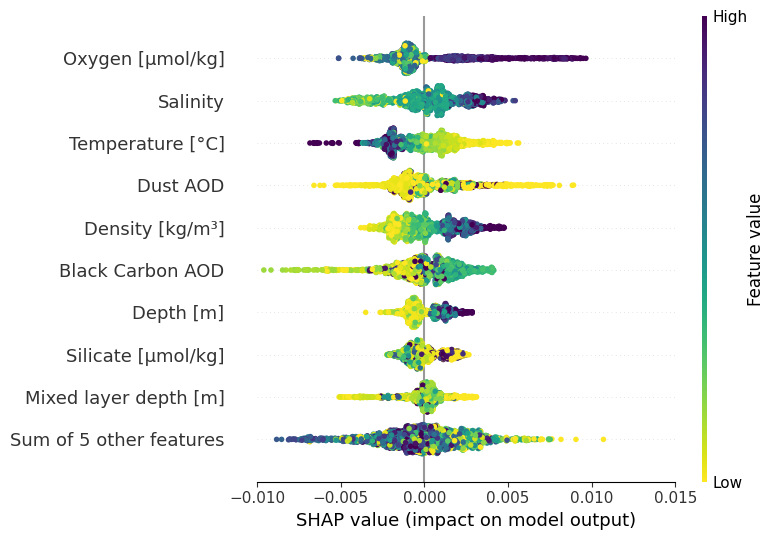

In [53]:
plt.figure()
shap.plots.beeswarm(shap_values, color = 'viridis_r', show=False)
ax = plt.gca()
ax.set_xlim(-0.01, 0.015)
plt.tight_layout()

plt.savefig('../../Figures/For_ms/67Pb_no-coords_shap_beeswarm.png', dpi = 400)

In [54]:
feature_names = shap_values.feature_names
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
main_features = shap_importance[0:9].col_name.values
shap_importance.set_index(np.arange(1, len(shap_importance)+1), inplace=True)

shap_importance.to_csv('../../Tables/For_ms/67Pb_no-coords_shap_importance.csv', index=False)
shap_importance


col_name  feature_importance_vals
1                        Oxygen [µmol/kg]                 0.001910
2                                Salinity                 0.001696
3                        Temperature [°C]                 0.001546
4                                Dust AOD                 0.001535
5                         Density [kg/m³]                 0.001439
6                        Black Carbon AOD                 0.001410
7                               Depth [m]                 0.000862
8                      Silicate [µmol/kg]                 0.000834
9                   Mixed layer depth [m]                 0.000741
10                    Bottom distance [m]                 0.000736
11                  Chlorophyll-a [mg/m³]                 0.000703
12                    Phosphate [µmol/kg]                 0.000640
13                      Nitrate [µmol/kg]                 0.000338
14  Apparent oxygen utilization [µmol/kg]                 0.000326

In [55]:
reverse_name_map = {v: k for k, v in name_map.items()}
reverse_name_map

{'Dust AOD': 'Dust AOD',
 'Temperature [°C]': 'Temperature',
 'Black Carbon AOD': 'Black Carbon AOD',
 'Salinity': 'Salinity',
 'Oxygen [µmol/kg]': 'Oxygen',
 'Density [kg/m³]': 'Sigma',
 'Silicate [µmol/kg]': 'Silicate',
 'Mixed layer depth [m]': 'MLD',
 'Bottom distance [m]': 'Bottom_distance',
 'Chlorophyll-a [mg/m³]': 'Chlorophyll-a',
 'Phosphate [µmol/kg]': 'Phosphate',
 'Nitrate [µmol/kg]': 'Nitrate',
 'Depth [m]': 'WOD_depth',
 'Apparent oxygen utilization [µmol/kg]': 'AOU'}

1e-06 1
[1.00000000e-06 3.16227766e-05 1.00000000e-03 3.16227766e-02
 1.00000000e+00]


Attempt to set non-positive xlim on a log-scaled axis will be ignored.


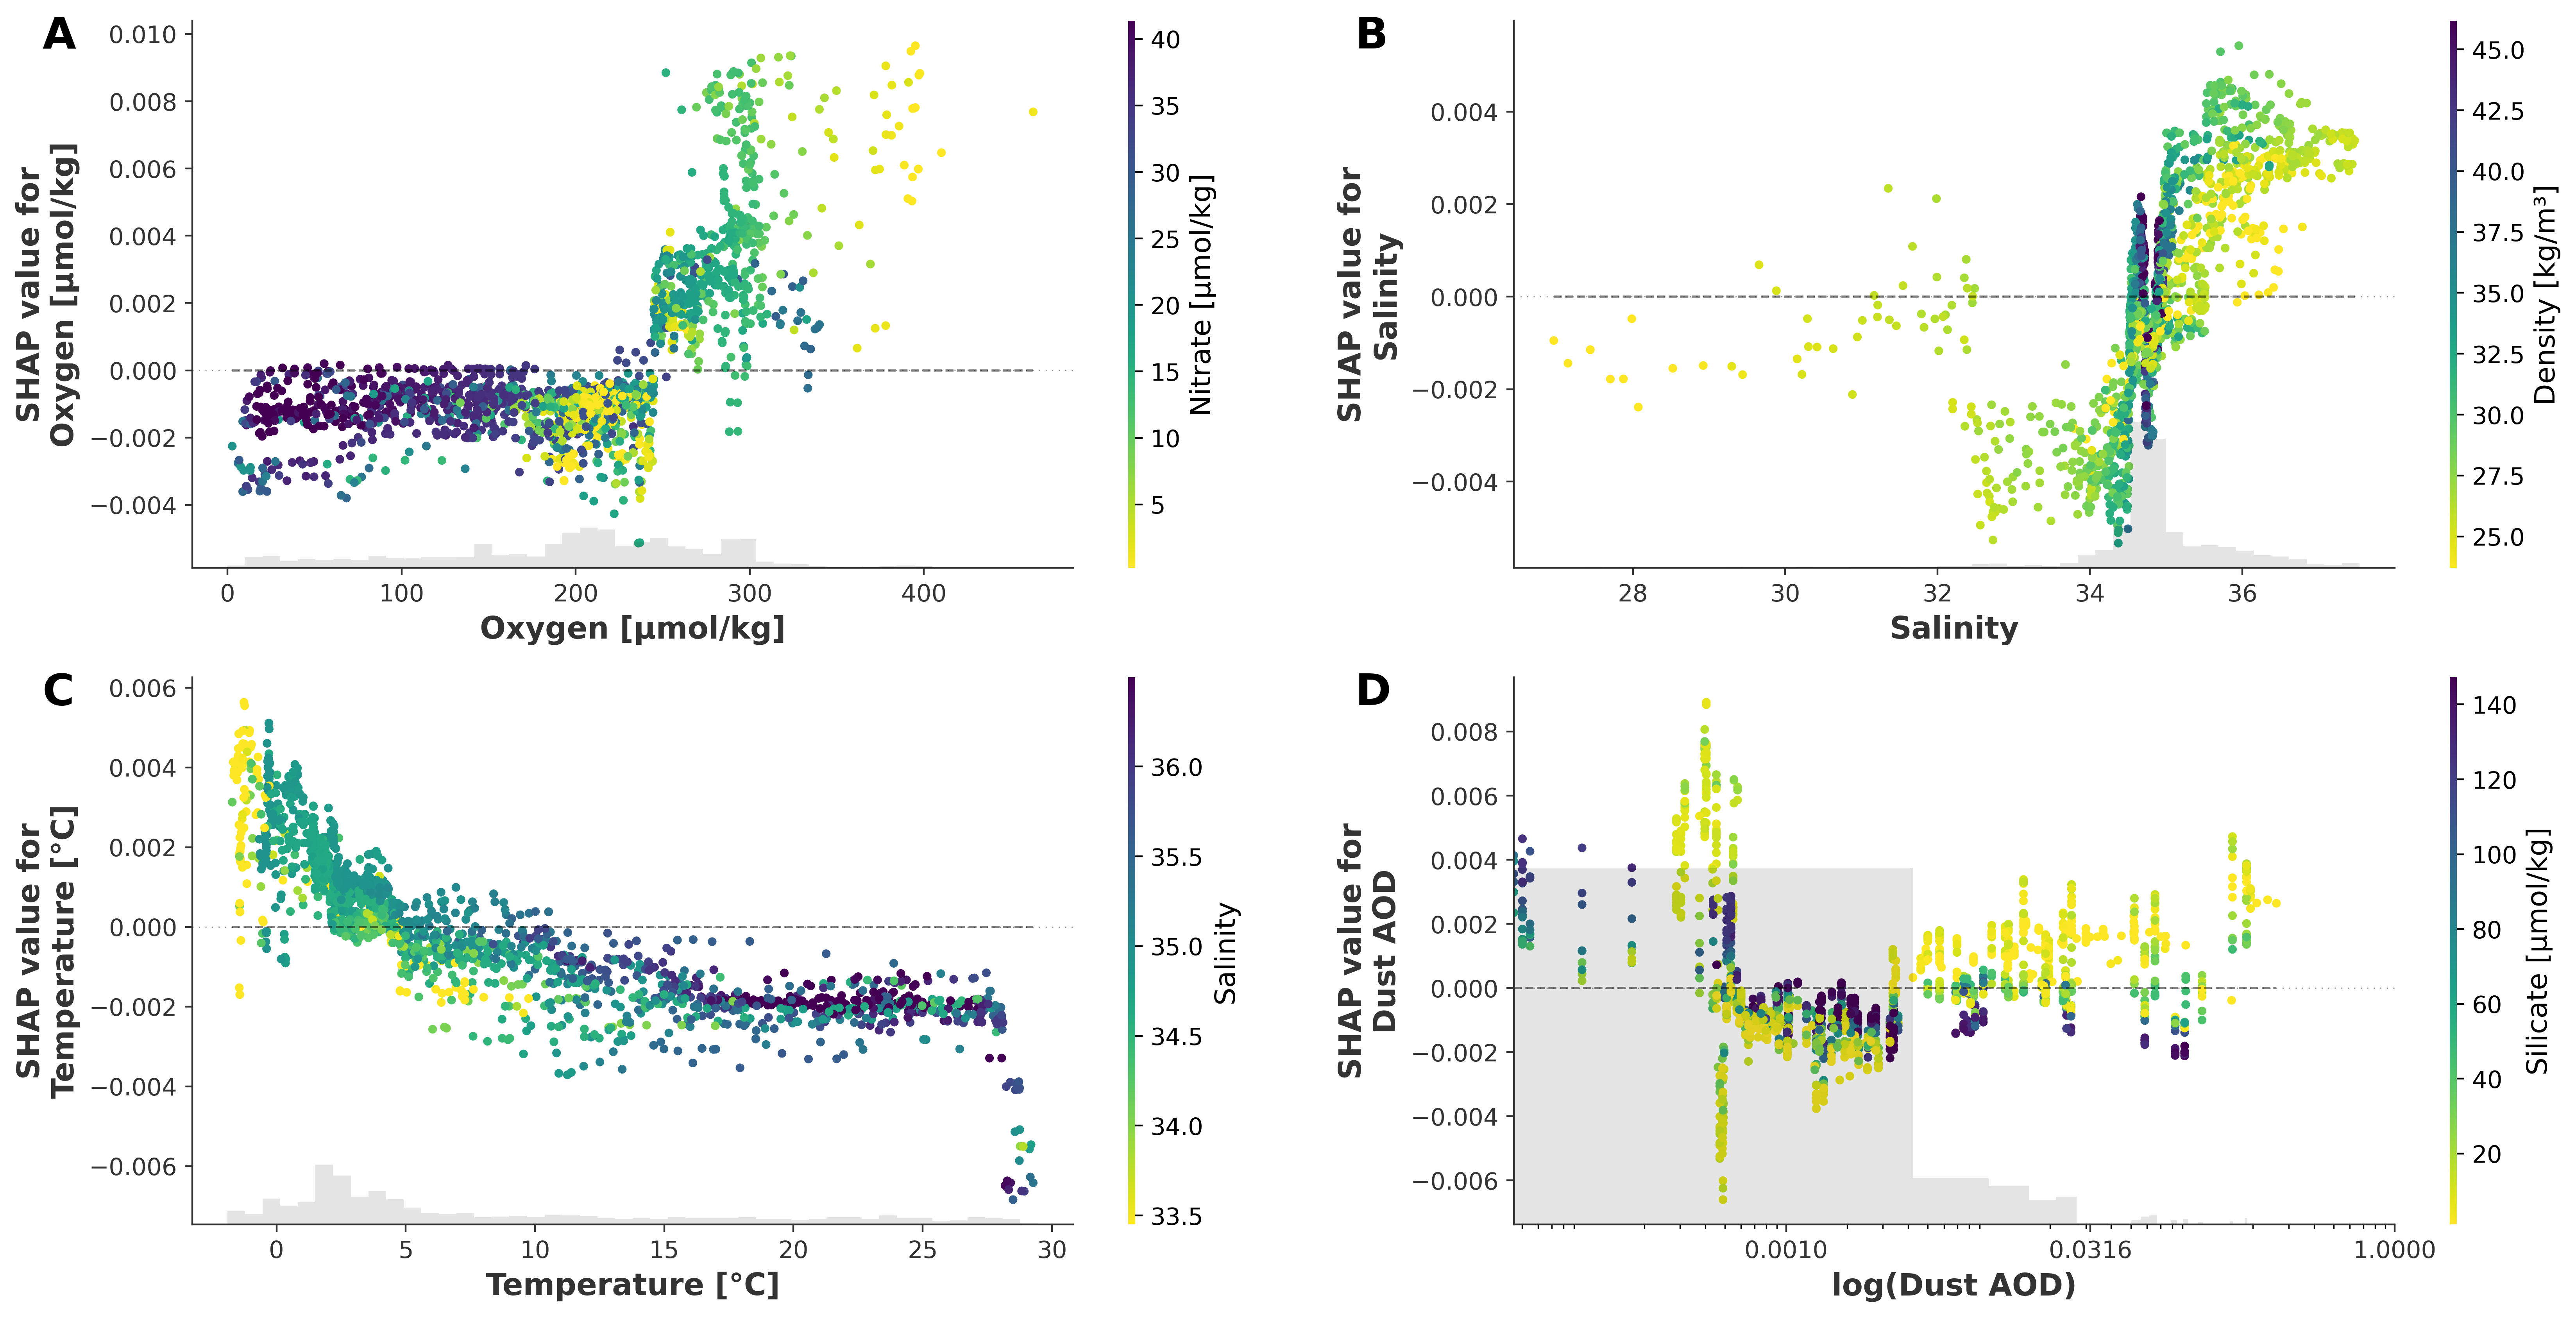

In [101]:
nrows = 2
ncols = 2
fig_label = ['A', 'B', 'C', 'D']

fig, ax = plt.subplots(nrows,ncols, figsize=(20, 10), dpi=400)
for i, ax_flt in zip(range(len(main_features)), ax.flat):
    shap.plots.scatter(shap_values[:,main_features[i]], ax=ax_flt, show=False, color=shap_values, cmap = 'viridis_r')
    ax_flt.hlines(0, xmin = all_X[reverse_name_map[main_features[i]]].min(), xmax = all_X[reverse_name_map[main_features[i]]].max(), linestyles='dashed', linewidth=1, color='black', alpha=0.5)
    ax_flt.set_xlabel(main_features[i], fontweight='bold', fontsize = 14)
    ax_flt.set_ylabel(f'SHAP value for\n{main_features[i]}', fontweight='bold', fontsize = 14)
    if i in [0,2]:
        ax_flt.text(-0.17, 0.95, f'{fig_label[i]}', transform=ax_flt.transAxes, fontsize=20, fontweight='bold')
    else:
        ax_flt.text(-0.18, 0.95, f'{fig_label[i]}', transform=ax_flt.transAxes, fontsize=20, fontweight='bold')
    if main_features[i] == 'Dust AOD':
        ax_flt.set_xscale('log')
        xmin = 1e-6
        xmax = 1
        print(xmin,xmax)
        ticks = np.logspace(np.floor(np.log10(xmin)), np.ceil(np.log10(xmax)), num=5)
        print(ticks)
        ax_flt.set_xticks(ticks)
        ax_flt.get_xaxis().set_major_formatter(plt.ScalarFormatter())
        ax_flt.set_xlim(np.floor(np.log10(xmin)), np.ceil(np.log10(xmax)))
        ax_flt.set_xlabel(f'log({main_features[i]})', fontweight='bold', fontsize=14)
        

plt.savefig('../../Figures/For_ms/67Pb_no-coords_shap_scatter-dependence_4panels.png', dpi = 400)  


# <strong style = "color:Yellow"> Map global distribution </strong>

In [18]:
with open('../../Data/Global-prediction_masked-df_no-coords.csv', mode='r', newline='') as csvfile:
    prediction_df_latlon = pd.read_csv(csvfile)
prediction_df_latlon

WOD_latitude [degrees_north]  WOD_longitude [degrees_east]  Depth  \
0                               -76.5                        -179.5      0   
1                               -76.5                        -179.5      5   
2                               -76.5                        -179.5     10   
3                               -76.5                        -179.5     15   
4                               -76.5                        -179.5     20   
...                               ...                           ...    ...   
3300568                          89.5                         179.5   3700   
3300569                          89.5                         179.5   3800   
3300570                          89.5                         179.5   3900   
3300571                          89.5                         179.5   4000   
3300572                          89.5                         179.5   4100   

         Salinity  Temperature  Silicate  Nitrate  Phosphate   Oxygen     AOU  \
0          34.336       -1.489    66.786   23.699      1.731  329.686  32.191   
1          34.338       -1.504    65.701   23.764      1.726  328.966  32.839   
2          34.340       -1.518    66.094   23.987      1.735  327.762  33.466   
3          34.349       -1.461    66.145   24.062      1.746  326.322  34.773   
4          34.349       -1.469    66.372   24.318      1.761  325.139  36.318   
...           ...          ...       ...      ...        ...      ...     ...   
3300568    34.953       -0.527    11.339   14.569      1.004  297.053  59.287   
3300569    34.952       -0.518    11.356   14.554      1.004  296.844  59.387   
3300570    34.954       -0.546    11.325   14.518      1.006  297.770  58.866   
3300571    34.942       -0.670    11.228   14.473      1.008  299.008  58.407   
3300572    34.944       -0.658    11.021   14.465      1.007  299.160  58.156   

             MLD   Sigma  Chlorophyll-a  Black Carbon AOD  Dust AOD  \
0        290.354  27.701          0.465             0.001       0.0   
1        290.354  27.724          0.465             0.001       0.0   
2        290.354  27.721          0.465             0.001       0.0   
3        290.354  27.754          0.465             0.001       0.0   
4        290.354  27.782          0.465             0.001       0.0   
...          ...     ...            ...               ...       ...   
3300568   36.069  45.408          0.090             0.003       0.0   
3300569   36.069  45.860          0.090             0.003       0.0   
3300570   36.069  46.321          0.090             0.003       0.0   
3300571   36.069  46.788          0.090             0.003       0.0   
3300572   36.069  47.237          0.090             0.003       0.0   

         Bottom_distance  Ocean_basin  
0                  605.0         10.0  
1                  600.0         10.0  
2                  595.0         10.0  
3                  590.0         10.0  
4                  585.0         10.0  
...                  ...          ...  
3300568            450.0         11.0  
3300569            350.0         11.0  
3300570            250.0         11.0  
3300571            150.0         11.0  
3300572             50.0         11.0  

[3300573 rows x 17 columns]

In [19]:
prediction_df = prediction_df_latlon.drop(['WOD_latitude [degrees_north]', 'WOD_longitude [degrees_east]', 'Ocean_basin'], axis=1)
prediction_df.rename(columns={'Depth': 'WOD_depth'}, inplace=True)

In [20]:
global_preds = best_xgb_model.predict(prediction_df)
global_preds

array([1.1693568, 1.1693568, 1.1687822, ..., 1.1857195, 1.1867069,
       1.1855341], dtype=float32)

In [21]:
global_preds.min(), global_preds.max()

(1.1437417, 1.1997075)

In [22]:
prediction_df['Pb_206_207'] = global_preds
prediction_df_latlon['Pb_206_207'] = global_preds

In [23]:
prediction_df_latlon = prediction_df_latlon.replace({'Ocean_basin': {1.0: 'Atlantic', 2.0: 'Pacific', 3.0: 'Indian', 10.0: 'Southern', 11.0: 'Arctic'}})
prediction_df_latlon

WOD_latitude [degrees_north]  WOD_longitude [degrees_east]  Depth  \
0                               -76.5                        -179.5      0   
1                               -76.5                        -179.5      5   
2                               -76.5                        -179.5     10   
3                               -76.5                        -179.5     15   
4                               -76.5                        -179.5     20   
...                               ...                           ...    ...   
3300568                          89.5                         179.5   3700   
3300569                          89.5                         179.5   3800   
3300570                          89.5                         179.5   3900   
3300571                          89.5                         179.5   4000   
3300572                          89.5                         179.5   4100   

         Salinity  Temperature  Silicate  Nitrate  Phosphate   Oxygen     AOU  \
0          34.336       -1.489    66.786   23.699      1.731  329.686  32.191   
1          34.338       -1.504    65.701   23.764      1.726  328.966  32.839   
2          34.340       -1.518    66.094   23.987      1.735  327.762  33.466   
3          34.349       -1.461    66.145   24.062      1.746  326.322  34.773   
4          34.349       -1.469    66.372   24.318      1.761  325.139  36.318   
...           ...          ...       ...      ...        ...      ...     ...   
3300568    34.953       -0.527    11.339   14.569      1.004  297.053  59.287   
3300569    34.952       -0.518    11.356   14.554      1.004  296.844  59.387   
3300570    34.954       -0.546    11.325   14.518      1.006  297.770  58.866   
3300571    34.942       -0.670    11.228   14.473      1.008  299.008  58.407   
3300572    34.944       -0.658    11.021   14.465      1.007  299.160  58.156   

             MLD   Sigma  Chlorophyll-a  Black Carbon AOD  Dust AOD  \
0        290.354  27.701          0.465             0.001       0.0   
1        290.354  27.724          0.465             0.001       0.0   
2        290.354  27.721          0.465             0.001       0.0   
3        290.354  27.754          0.465             0.001       0.0   
4        290.354  27.782          0.465             0.001       0.0   
...          ...     ...            ...               ...       ...   
3300568   36.069  45.408          0.090             0.003       0.0   
3300569   36.069  45.860          0.090             0.003       0.0   
3300570   36.069  46.321          0.090             0.003       0.0   
3300571   36.069  46.788          0.090             0.003       0.0   
3300572   36.069  47.237          0.090             0.003       0.0   

         Bottom_distance Ocean_basin  Pb_206_207  
0                  605.0    Southern    1.169357  
1                  600.0    Southern    1.169357  
2                  595.0    Southern    1.168782  
3                  590.0    Southern    1.168636  
4                  585.0    Southern    1.168636  
...                  ...         ...         ...  
3300568            450.0      Arctic    1.184894  
3300569            350.0      Arctic    1.185400  
3300570            250.0      Arctic    1.185719  
3300571            150.0      Arctic    1.186707  
3300572             50.0      Arctic    1.185534  

[3300573 rows x 18 columns]

In [24]:
prediction_df_latlon.to_csv('../../Data/67Pb-predictions-no_coords.csv', index=False)

In [25]:
import gsw 

prediction_df_latlon['pressure'] = gsw.p_from_z(-prediction_df_latlon['Depth'], prediction_df_latlon['WOD_latitude [degrees_north]'])
prediction_df_latlon['conservative_temperature'] = gsw.CT_from_t(prediction_df_latlon['Salinity'], prediction_df_latlon['Temperature'], prediction_df_latlon['pressure'])
prediction_df_latlon['potential_density'] = gsw.sigma0(prediction_df_latlon['Salinity'], prediction_df_latlon['conservative_temperature'])
prediction_df_latlon

WOD_latitude [degrees_north]  WOD_longitude [degrees_east]  Depth  \
0                               -76.5                        -179.5      0   
1                               -76.5                        -179.5      5   
2                               -76.5                        -179.5     10   
3                               -76.5                        -179.5     15   
4                               -76.5                        -179.5     20   
...                               ...                           ...    ...   
3300568                          89.5                         179.5   3700   
3300569                          89.5                         179.5   3800   
3300570                          89.5                         179.5   3900   
3300571                          89.5                         179.5   4000   
3300572                          89.5                         179.5   4100   

         Salinity  Temperature  Silicate  Nitrate  Phosphate   Oxygen     AOU  \
0          34.336       -1.489    66.786   23.699      1.731  329.686  32.191   
1          34.338       -1.504    65.701   23.764      1.726  328.966  32.839   
2          34.340       -1.518    66.094   23.987      1.735  327.762  33.466   
3          34.349       -1.461    66.145   24.062      1.746  326.322  34.773   
4          34.349       -1.469    66.372   24.318      1.761  325.139  36.318   
...           ...          ...       ...      ...        ...      ...     ...   
3300568    34.953       -0.527    11.339   14.569      1.004  297.053  59.287   
3300569    34.952       -0.518    11.356   14.554      1.004  296.844  59.387   
3300570    34.954       -0.546    11.325   14.518      1.006  297.770  58.866   
3300571    34.942       -0.670    11.228   14.473      1.008  299.008  58.407   
3300572    34.944       -0.658    11.021   14.465      1.007  299.160  58.156   

         ...   Sigma  Chlorophyll-a  Black Carbon AOD  Dust AOD  \
0        ...  27.701          0.465             0.001       0.0   
1        ...  27.724          0.465             0.001       0.0   
2        ...  27.721          0.465             0.001       0.0   
3        ...  27.754          0.465             0.001       0.0   
4        ...  27.782          0.465             0.001       0.0   
...      ...     ...            ...               ...       ...   
3300568  ...  45.408          0.090             0.003       0.0   
3300569  ...  45.860          0.090             0.003       0.0   
3300570  ...  46.321          0.090             0.003       0.0   
3300571  ...  46.788          0.090             0.003       0.0   
3300572  ...  47.237          0.090             0.003       0.0   

         Bottom_distance  Ocean_basin Pb_206_207     pressure  \
0                  605.0     Southern   1.169357    -0.000000   
1                  600.0     Southern   1.169357     5.052873   
2                  595.0     Southern   1.168782    10.105870   
3                  590.0     Southern   1.168636    15.158991   
4                  585.0     Southern   1.168636    20.212236   
...                  ...          ...        ...          ...   
3300568            450.0       Arctic   1.184894  3773.425080   
3300569            350.0       Arctic   1.185400  3876.312831   
3300570            250.0       Arctic   1.185719  3979.247030   
3300571            150.0       Arctic   1.186707  4082.227592   
3300572             50.0       Arctic   1.185534  4185.254434   

         conservative_temperature  potential_density  
0                       -1.485296          27.503539  
1                       -1.500400          27.505626  
2                       -1.514504          27.507679  
3                       -1.457637          27.513160  
4                       -1.465740          27.513417  
...                           ...                ...  
3300568                 -0.764481          27.974008  
3300569                 -0.765461          27.973245  
3300570           

In [26]:
prediction_df_latlon_idxs = prediction_df_latlon.set_index(['WOD_latitude [degrees_north]', 'WOD_longitude [degrees_east]', 'Depth'])
prediction_df_latlon_idxs
prediction_xr = xr.Dataset.from_dataframe(prediction_df_latlon_idxs)
prediction_xr

<xarray.Dataset>
Dimensions:                       (WOD_latitude [degrees_north]: 167,
                                   WOD_longitude [degrees_east]: 360, Depth: 102)
Coordinates:
  * WOD_latitude [degrees_north]  (WOD_latitude [degrees_north]) float64 -76....
  * WOD_longitude [degrees_east]  (WOD_longitude [degrees_east]) float64 -179...
  * Depth                         (Depth) int64 0 5 10 15 ... 5300 5400 5500
Data variables: (12/18)
    Salinity                      (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    Temperature                   (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    Silicate                      (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    Nitrate                       (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    Phosphate                     (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    Oxygen                        (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    ...                            ...
    Bottom_distance               (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    Ocean_basin                   (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) object ...
    Pb_206_207                    (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float32 ...
    pressure                      (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    conservative_temperature      (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...
    potential_density             (WOD_latitude [degrees_north], WOD_longitude [degrees_east], Depth) float64 ...

In [27]:
lat = prediction_xr.variables['WOD_latitude [degrees_north]'][:]
lon = prediction_xr.variables['WOD_longitude [degrees_east]'][:]

In [28]:
variable_names = list(prediction_xr.keys())

In [29]:
surface_df = {}
intermediate_df = {}
deep_df = {}
bottom_df = {}

for variable in variable_names:
    if variable not in surface_df.keys():
        surface_df[variable] = []
    surface_df[variable].append(prediction_xr.variables[variable][:,:,np.where(prediction_xr.variables['Depth'][:] == 10)[0][0]])
    if variable not in intermediate_df.keys():
        intermediate_df[variable] = []
    intermediate_df[variable].append(prediction_xr.variables[variable][:,:,np.where(prediction_xr.variables['Depth'][:] == 1000)[0][0]])
    if variable not in deep_df.keys():
        deep_df[variable] = []
    deep_df[variable].append(prediction_xr.variables[variable][:,:,np.where(prediction_xr.variables['Depth'][:] == 2500)[0][0]])
    if variable not in bottom_df.keys():
        bottom_df[variable] = []
    bottom_df[variable].append(prediction_xr.variables[variable][:,:,np.where(prediction_xr.variables['Depth'][:] == 4000)[0][0]])


In [30]:
dfs = [surface_df, intermediate_df, deep_df, bottom_df]
ranges = [np.arange(5,20,5), np.arange(900,1150,50), np.arange(1900,2200,100), np.arange(3800,4300,100)]
titles =['10 m', '1000 m', '2500 m', '4000 m']

### Main Figures

facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no effect as it has been defined as "never".
facecolor will have no ef

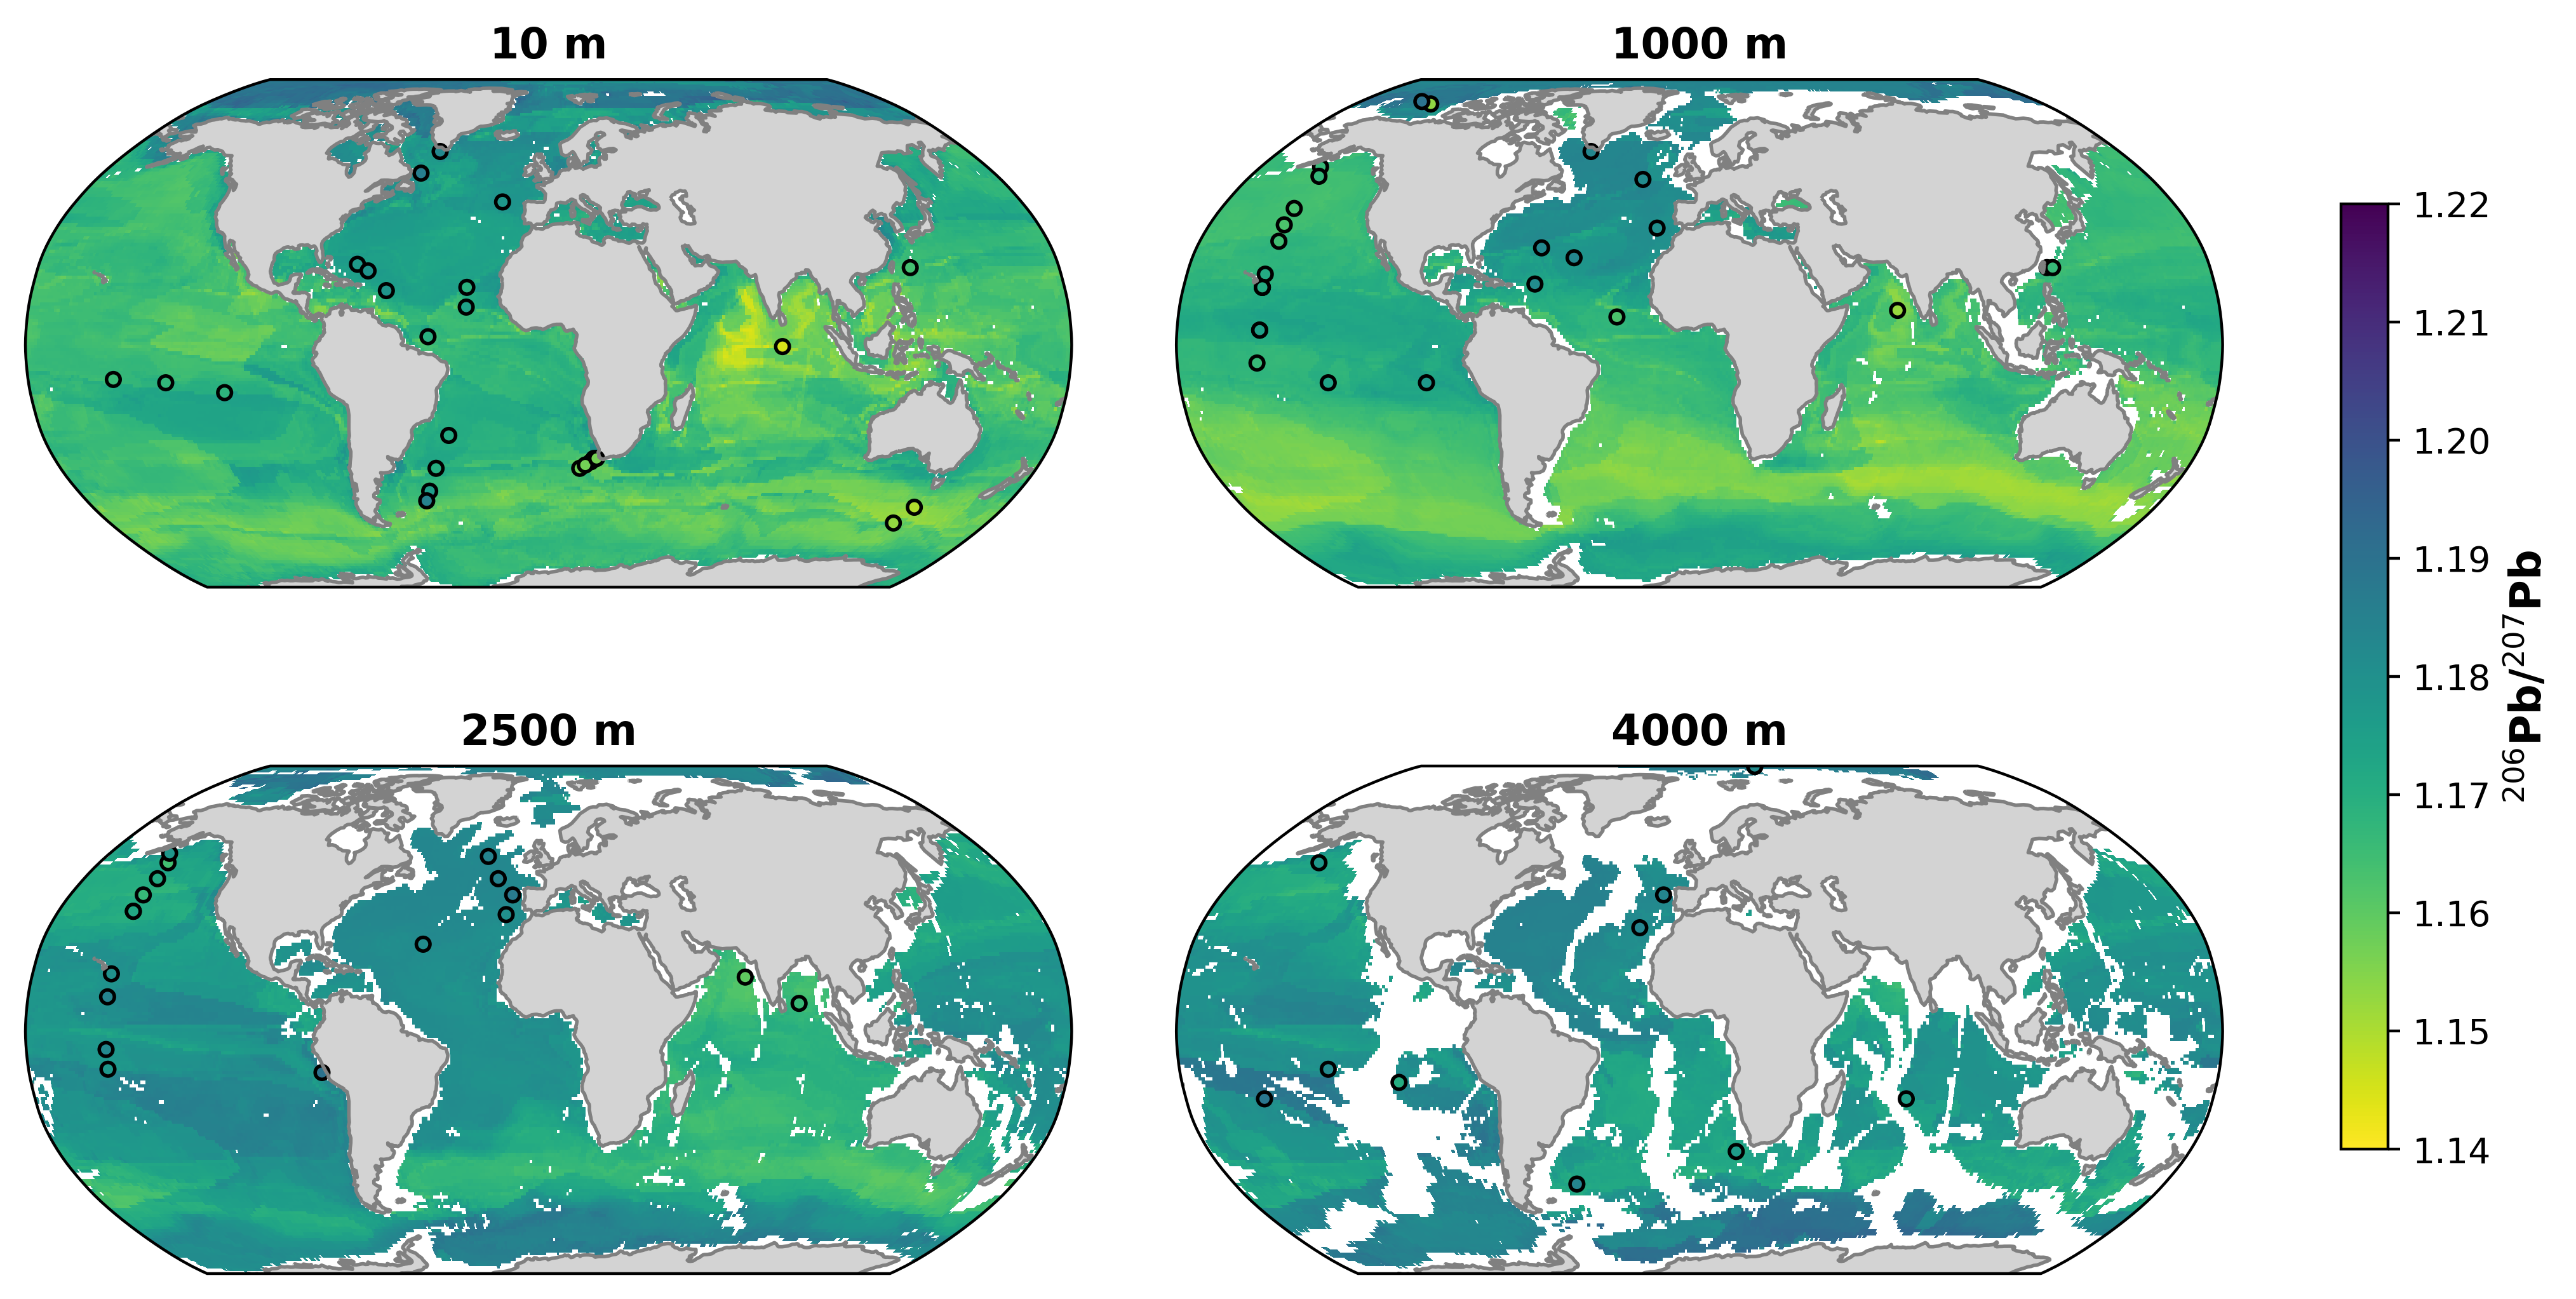

In [31]:
fig, axes = plt.subplots(2,2, figsize=(12,7), dpi = 400, subplot_kw=dict(projection=ccrs.Robinson()), gridspec_kw = {'wspace':0.1, 'hspace':0.005})

for i, ax in enumerate(fig.axes):
    cs = ax.pcolormesh(lon, lat, dfs[i]['Pb_206_207'][0], cmap = 'viridis_r', vmin =1.14, vmax=1.22, transform=ccrs.PlateCarree(),alpha=1, shading='auto')
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.COASTLINE, color = 'grey')
    ax.scatter(merged_df[merged_df['WOD_depth_x'].isin(ranges[i])]['WOD_longitude [degrees_east]'], merged_df[merged_df['WOD_depth_x'].isin(ranges[i])]['WOD_latitude [degrees_north]'], c = merged_df[merged_df['WOD_depth_x'].isin(ranges[i])]['y_test'], cmap = 'viridis_r', vmin =1.14, vmax = 1.22, edgecolors='black', s = 15, transform=ccrs.PlateCarree())
    ax.set_title(titles[i], fontweight='bold')
    
fig.colorbar(cs, ax=axes.ravel().tolist(), orientation = 'vertical', fraction = 0.02, pad = 0.05).set_label(label = '$^{206}$Pb/$^{207}$Pb', fontweight='bold', fontsize=12)

plt.savefig('../../Figures/For_ms/Pb_67-no-coords_maps_pcolormesh.jpg')

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


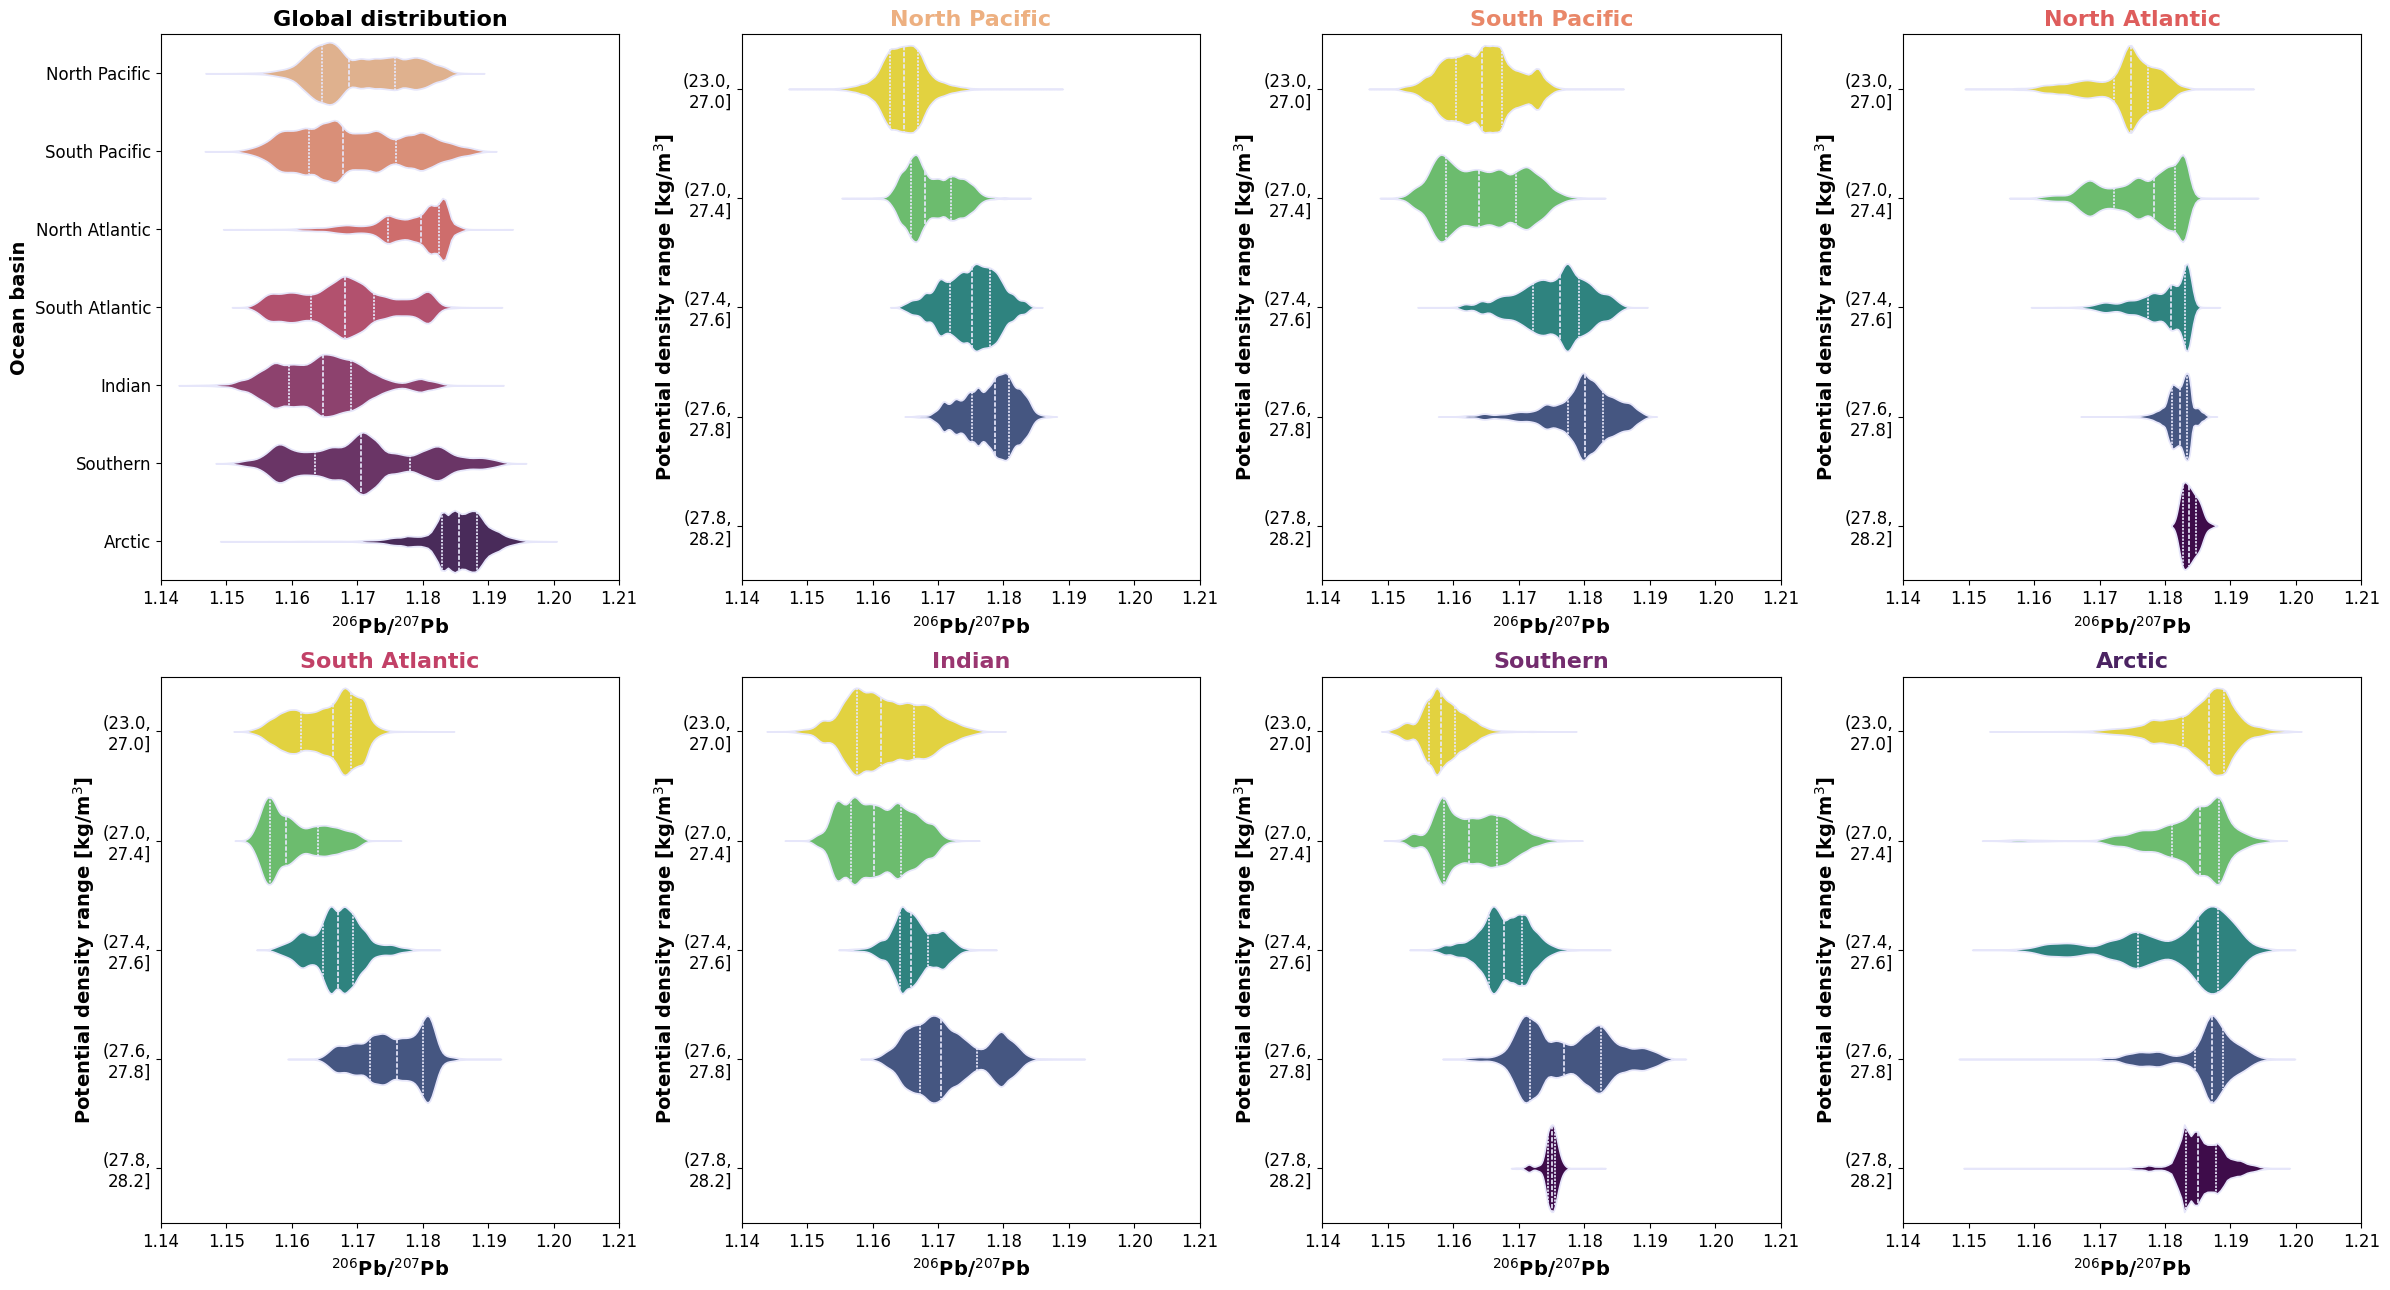

In [32]:
prediction_df_latlon_NS = prediction_df_latlon.copy()

for basin in ['Pacific', 'Atlantic']:
    prediction_df_latlon_NS.loc[(prediction_df_latlon_NS['Ocean_basin'] == basin) & (prediction_df_latlon_NS['WOD_latitude [degrees_north]'] >= 0), 'Ocean_basin'] = f'North {basin}'
    prediction_df_latlon_NS.loc[(prediction_df_latlon_NS['Ocean_basin'] == basin) & (prediction_df_latlon_NS['WOD_latitude [degrees_north]'] < 0), 'Ocean_basin'] = f'South {basin}'

basins = ['North Pacific', 'South Pacific', 'North Atlantic', 'South Atlantic', 'Indian', 'Southern', 'Arctic']
potential_densities = [23, 27, 27.4, 27.6, 27.8, 28.2]
f_colors = []
basin_colors = []

fig, axes = plt.subplots(2, int((len(basins)+1)/2), figsize=(24,13))

for i in np.linspace(0, 255, len(basins)).astype(int):
    basin_colors.append(sns.color_palette('flare', 256)[i])

for i in np.linspace(0, 255, len(potential_densities)-1).astype(int):
    f_colors.append(sns.color_palette('viridis_r', 256)[i])

for j, ax in enumerate(axes.flat):
    if j == 0:
        sns.violinplot(x='Pb_206_207', hue='Ocean_basin', y='Ocean_basin', data=prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin'].isin(basins)], ax=ax, palette=basin_colors, order=basins, hue_order=basins, linecolor='lavender', inner='quart', legend=False)        
        ax.set_xlim(1.14, 1.21)
        ax.set_title('Global distribution', fontweight='bold', fontsize = 16)
        ax.set_ylabel('Ocean basin', fontweight='bold', fontsize = 14)
        ax.set_xlabel('$^{206}$Pb/$^{207}$Pb', fontweight='bold', fontsize = 14)
        ax.tick_params(axis='both', labelsize=12)

    else:
        basin_df = prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin'] == basins[j-1]]
        sns.violinplot(x='Pb_206_207', y=pd.cut(prediction_df_latlon_NS.potential_density, potential_densities), hue=pd.cut(prediction_df_latlon_NS.potential_density, potential_densities), data=basin_df, ax=ax, linecolor='lavender', palette=f_colors, inner='quart', legend=False)
        ax.set_title(basins[j-1], fontweight='bold', fontsize = 16, color = basin_colors[j-1])
        ax.set_xlim(1.14, 1.21)
        ax.set_ylabel('Potential density range [kg/m$^{3}$]', fontweight='bold', fontsize = 14)
        ax.set_xlabel('$^{206}$Pb/$^{207}$Pb', fontweight='bold', fontsize = 14)
        ax.set_yticklabels(['(23.0,\n27.0]', '(27.0,\n27.4]', '(27.4,\n27.6]', '(27.6,\n27.8]', '(27.8,\n28.2]'])
        ax.tick_params(axis='both', labelsize=12)

plt.tight_layout(w_pad=1)

plt.savefig('../../Figures/For_ms/Pb_67_violin-predictions_no-coords-NS-density.jpg', dpi = 400)

### Additional Figures

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


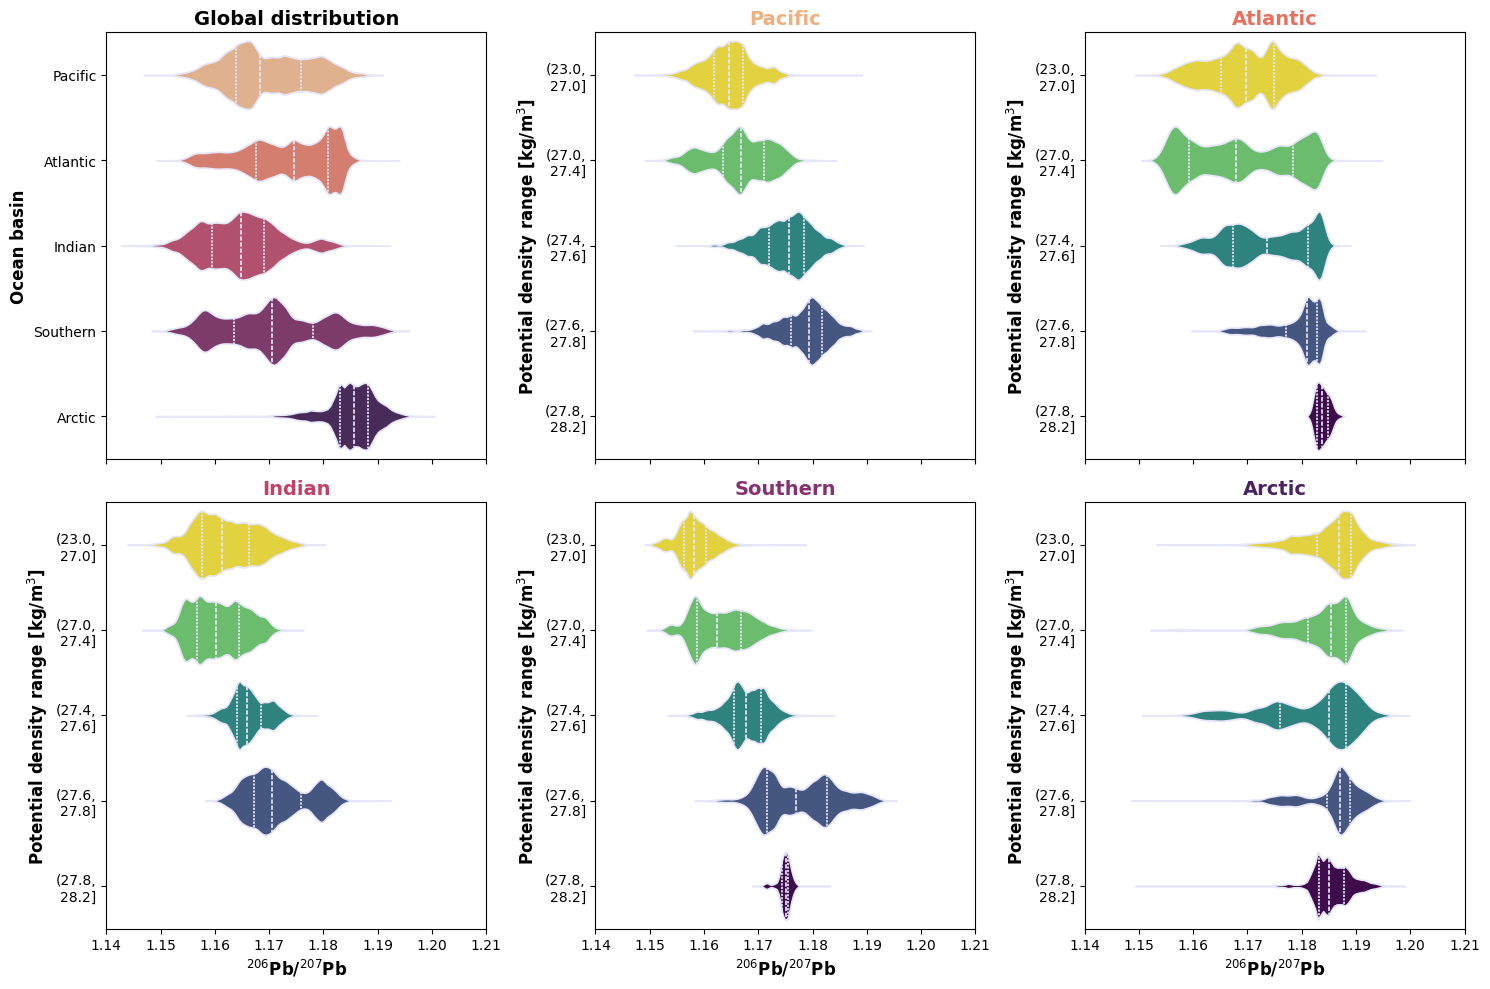

In [33]:
basins = ['Pacific', 'Atlantic', 'Indian', 'Southern', 'Arctic']
potential_densities = [23, 27, 27.4, 27.6, 27.8, 28.2]
colors = []
basin_colors = []

fig, axes = plt.subplots(2, int((len(basins)+1)/2), sharex=True, figsize=(15,10))

for i in np.linspace(0, 255, 5).astype(int):
    colors.append(sns.color_palette('viridis_r', 256)[i])
    basin_colors.append(sns.color_palette('flare', 256)[i])

for j, ax in enumerate(axes.flat):
    if j == 0:
        #sns.violinplot(x='Ocean_basin', hue='Ocean_basin', y='Pb_206_207', data=prediction_df_latlon[prediction_df_latlon['Ocean_basin'].isin(basins)], ax=ax, palette=basin_colors, linecolor='dimgrey', legend=False)
        sns.violinplot(x='Pb_206_207', hue='Ocean_basin', y='Ocean_basin', data=prediction_df_latlon[prediction_df_latlon['Ocean_basin'].isin(basins)], ax=ax, palette=basin_colors, order=basins, hue_order=basins, linecolor='lavender', inner='quart', legend=False)        
        ax.set_xlim(1.14, 1.21)
        ax.set_title('Global distribution', fontweight='bold', fontsize = 14)
        ax.set_ylabel('Ocean basin', fontweight='bold', fontsize = 12)
        ax.set_xlabel('$^{206}$Pb/$^{207}$Pb', fontweight='bold', fontsize = 12)

    else:
        basin_df = prediction_df_latlon[prediction_df_latlon['Ocean_basin'] == basins[j-1]]
        #sns.violinplot(x=pd.cut(prediction_df_latlon.potential_density, potential_densities), hue=pd.cut(prediction_df_latlon.potential_density, potential_densities), y='Pb_206_207', data=basin_df, ax=ax, linecolor='dimgrey', palette=colors, legend=False)
        sns.violinplot(x='Pb_206_207', y=pd.cut(prediction_df_latlon.potential_density, potential_densities), hue=pd.cut(prediction_df_latlon.potential_density, potential_densities), data=basin_df, ax=ax, linecolor='lavender', palette=colors, inner='quart', legend=False)
        ax.set_title(basins[j-1], fontweight='bold', fontsize = 14, color = basin_colors[j-1])
        ax.set_xlim(1.14, 1.21)
        ax.set_ylabel('Potential density range [kg/m$^{3}$]', fontweight='bold', fontsize = 12)
        ax.set_xlabel('$^{206}$Pb/$^{207}$Pb', fontweight='bold', fontsize = 12)
        ax.set_yticklabels(['(23.0,\n27.0]', '(27.0,\n27.4]', '(27.4,\n27.6]', '(27.6,\n27.8]', '(27.8,\n28.2]'])

plt.tight_layout(w_pad=1)

plt.savefig('../../Figures/For_ms/Pb_67_violin-predictions_no-coords-density.jpg', dpi = 400)

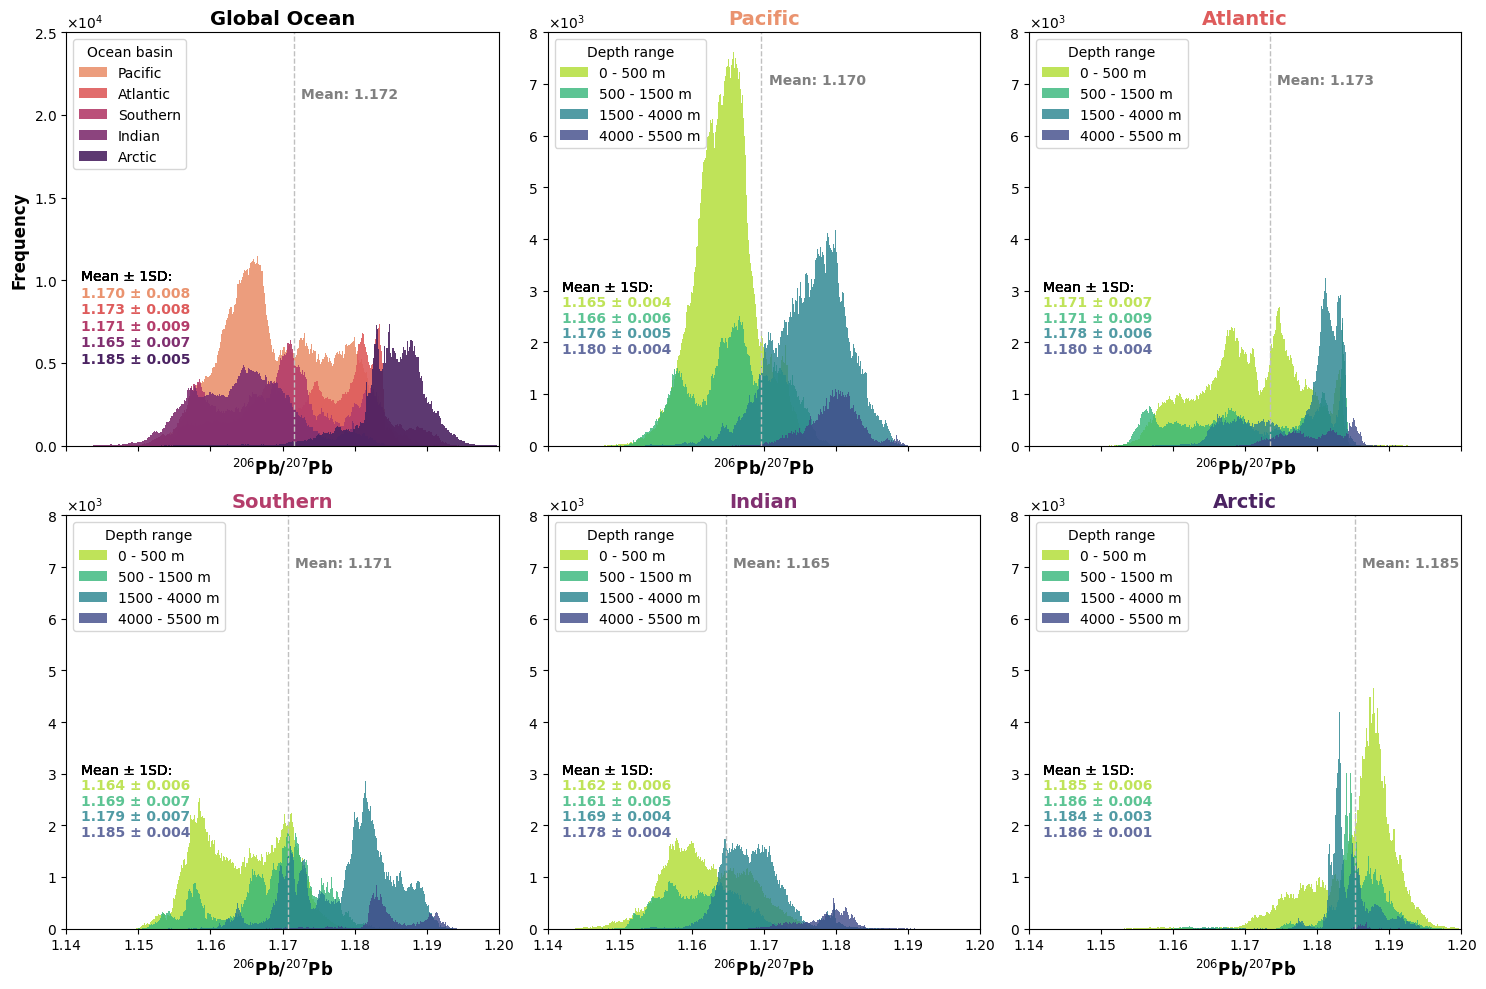

In [36]:
from matplotlib.patches import Rectangle

basins = ['Pacific', 'Atlantic', 'Southern', 'Indian', 'Arctic']
depths = [0, 500, 1500, 4000, 5500]
colors = []
basin_colors = []

fig, axes = plt.subplots(2, int((len(basins)+1)/2), sharex=True, figsize=(15,10))

for i in np.linspace(30, 255, 5).astype(int):
    colors.append(sns.color_palette('viridis_r', 256)[i])
    basin_colors.append(sns.color_palette('flare', 256)[i])

for j, ax in enumerate(axes.flat):
    if j == 0:
        for i in np.arange(0, len(basins)):
            basin_df = prediction_df_latlon[prediction_df_latlon['Ocean_basin'] == basins[i]]
            ax.hist(basin_df['Pb_206_207'], bins=300, alpha=0.9, color = basin_colors[i], label=basins[i])
            ax.set_ylabel('Frequency', fontweight='bold', fontsize = 12)
            ax.set_title('Global Ocean', fontweight='bold', fontsize = 14)
            ax.text(1.142, 10000, f'Mean ± 1SD:', color='black', fontsize=10)
            ax.text(1.142, (len(basins)-i)*1000+4000, f'{round(basin_df["Pb_206_207"].mean(), 3):.3f} ± {round(basin_df["Pb_206_207"].std(), 3):.3f}', color=basin_colors[i], fontsize=10, fontweight='bold')
            ax.set_ylim(0, 25000)               
        ax.vlines(prediction_df_latlon['Pb_206_207'].mean(), ymin=0, ymax=26000, color='silver', linestyle='dashed', linewidth=1)
        ax.text(prediction_df_latlon['Pb_206_207'].mean()+0.001, 21000, f'Mean: {round(prediction_df_latlon["Pb_206_207"].mean(), 3):.3f}', color='gray', fontsize=10, fontweight='bold')
        ax.legend(fontsize=10, loc='upper left', title='Ocean basin')

    else:
        for i in np.arange(0, len(depths)-1):
            depth_df = prediction_df_latlon[(prediction_df_latlon['Depth'] >= depths[i]) & (prediction_df_latlon['Depth'] < depths[i+1]) & (prediction_df_latlon['Ocean_basin'] == basins[j-1])]
            ax.hist(depth_df['Pb_206_207'], bins=300, alpha=0.8, color = colors[i], label=f'{depths[i]} - {depths[i+1]} m')
            ax.set_title(basins[j-1], fontweight='bold', fontsize = 14, color = basin_colors[j-1])
            ax.text(1.142, 3000, f'Mean ± 1SD:', color='black', fontsize=10, zorder=1)
            ax.text(1.142, (len(basins)-i)*300+1200, f'{round(depth_df["Pb_206_207"].mean(), 3):.3f} ± {round(depth_df["Pb_206_207"].std(), 3):.3f}', color=colors[i], fontsize=10, fontweight='bold', alpha = 0.8, zorder=1)
            ax.set_ylim(0, 8000)
        #rect = Rectangle((59, 1700), 19, 1600, edgecolor='black', facecolor='black', zorder=0)    
        #ax.add_patch(rect)
        ax.vlines(prediction_df_latlon[prediction_df_latlon['Ocean_basin']==basins[j-1]]['Pb_206_207'].mean(), ymin=0, ymax=26000, color='silver', linestyle='dashed', linewidth=1)
        ax.text(prediction_df_latlon[prediction_df_latlon['Ocean_basin']==basins[j-1]]['Pb_206_207'].mean()+0.001, 7000, f'Mean: {round(prediction_df_latlon[prediction_df_latlon["Ocean_basin"]==basins[j-1]]["Pb_206_207"].mean(), 3):.3f}', color='gray', fontsize=10, fontweight='bold')
        ax.legend(fontsize=10, loc='upper left', title='Depth range')
    
    ax.set_xlabel('$^{206}$Pb/$^{207}$Pb', fontweight='bold', fontsize = 12)
    ax.set_xlim(1.14,1.20)
    ax.ticklabel_format(axis='y', scilimits=(0,0), style='sci', useMathText=True)

plt.tight_layout(w_pad=1)

plt.savefig('../../Figures/Pb_67_hist-predictions_no-coords-depth.jpg', dpi = 400)

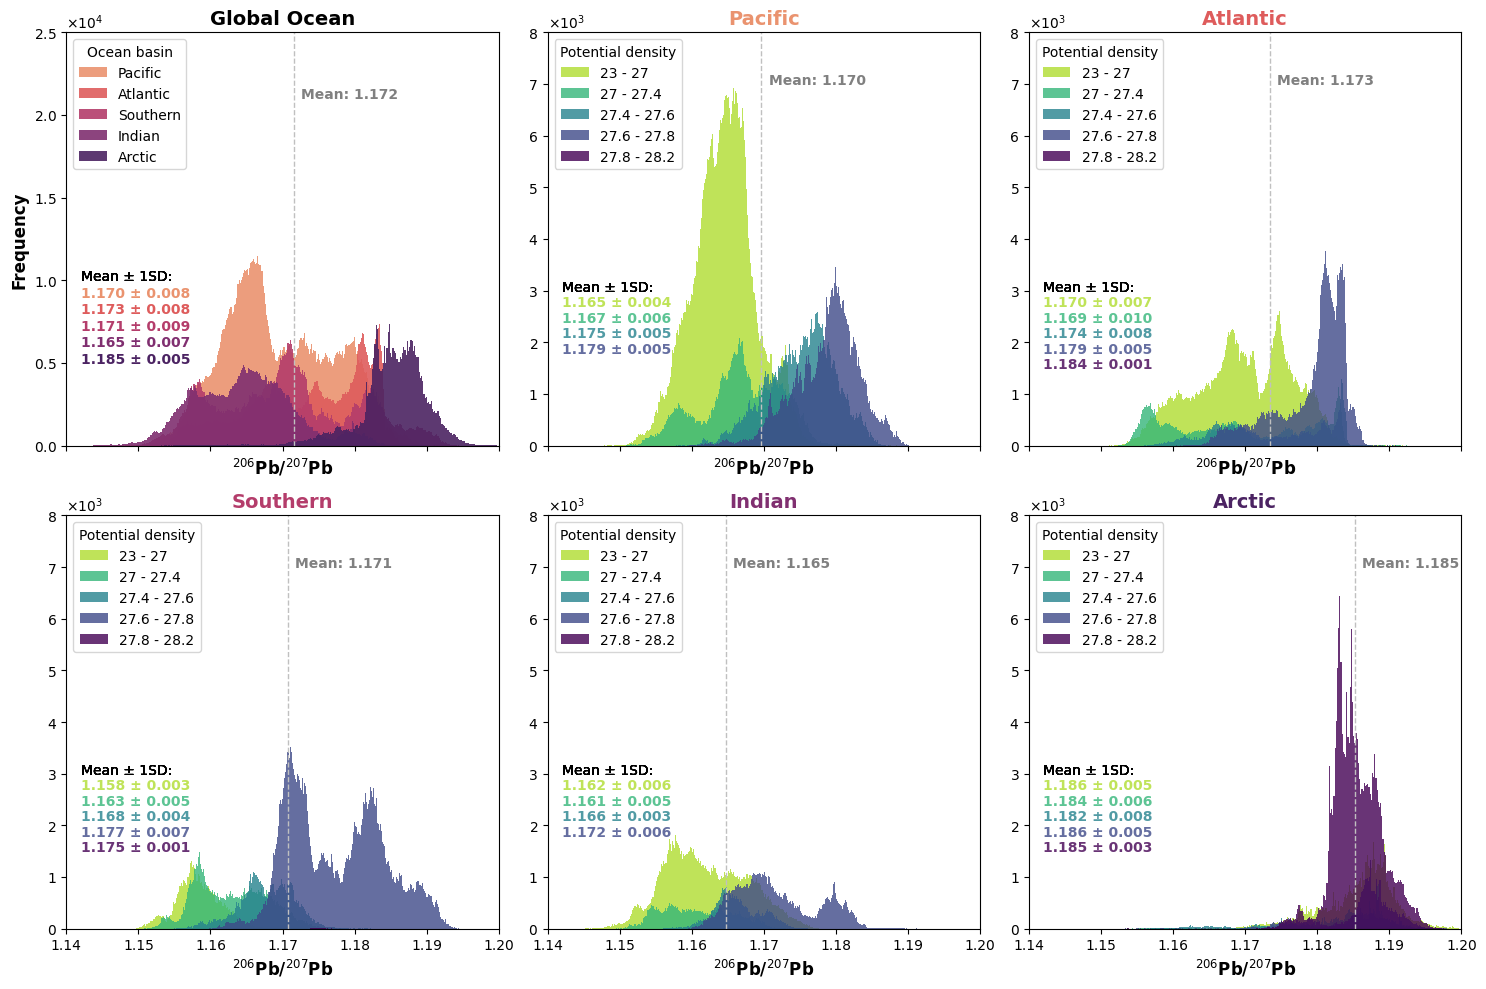

In [37]:
basins = ['Pacific', 'Atlantic', 'Southern', 'Indian', 'Arctic']
potential_densities = [23, 27, 27.4, 27.6, 27.8, 28.2]
colors = []
basin_colors = []

fig, axes = plt.subplots(2, int((len(basins)+1)/2), sharex=True, figsize=(15,10))

for i in np.linspace(30, 255, 5).astype(int):
    colors.append(sns.color_palette('viridis_r', 256)[i])
    basin_colors.append(sns.color_palette('flare', 256)[i])

for j, ax in enumerate(axes.flat):
    if j == 0:
        for i in np.arange(0, len(basins)):
            basin_df = prediction_df_latlon[prediction_df_latlon['Ocean_basin'] == basins[i]]
            ax.hist(basin_df['Pb_206_207'], bins=300, alpha=0.9, color = basin_colors[i], label=basins[i])
            ax.set_ylabel('Frequency', fontweight='bold', fontsize = 12)
            ax.set_title('Global Ocean', fontweight='bold', fontsize = 14)
            ax.text(1.142, 10000, f'Mean ± 1SD:', color='black', fontsize=10)
            ax.text(1.142, (len(basins)-i)*1000+4000, f'{round(basin_df["Pb_206_207"].mean(), 3):.3f} ± {round(basin_df["Pb_206_207"].std(), 3):.3f}', color=basin_colors[i], fontsize=10, fontweight='bold')
            ax.set_ylim(0, 25000)               
        ax.vlines(prediction_df_latlon['Pb_206_207'].mean(), ymin=0, ymax=26000, color='silver', linestyle='dashed', linewidth=1)
        ax.text(prediction_df_latlon['Pb_206_207'].mean()+0.001, 21000, f'Mean: {round(prediction_df_latlon["Pb_206_207"].mean(), 3):.3f}', color='gray', fontsize=10, fontweight='bold')
        ax.legend(fontsize=10, loc='upper left', title='Ocean basin')

    else:
        for i in np.arange(0, len(potential_densities)-1):
            density_df = prediction_df_latlon[(prediction_df_latlon['potential_density'] >= potential_densities[i]) & (prediction_df_latlon['potential_density'] < potential_densities[i+1]) & (prediction_df_latlon['Ocean_basin'] == basins[j-1])]
            ax.hist(density_df['Pb_206_207'], bins=300, alpha=0.8, color = colors[i], label=f'{potential_densities[i]} - {potential_densities[i+1]}')
            ax.set_title(basins[j-1], fontweight='bold', fontsize = 14, color = basin_colors[j-1])
            ax.text(1.142, 3000, f'Mean ± 1SD:', color='black', fontsize=10, zorder=1)
            if f'{round(density_df["Pb_206_207"].mean(), 3):.3f}' != 'nan':
                ax.text(1.142, (len(basins)-i)*300+1200, f'{round(density_df["Pb_206_207"].mean(), 3):.3f} ± {round(density_df["Pb_206_207"].std(), 3):.3f}', color=colors[i], fontsize=10, fontweight='bold', alpha = 0.8, zorder=1)
            ax.set_ylim(0, 8000)
        ax.vlines(prediction_df_latlon[prediction_df_latlon['Ocean_basin']==basins[j-1]]['Pb_206_207'].mean(), ymin=0, ymax=26000, color='silver', linestyle='dashed', linewidth=1)
        ax.text(prediction_df_latlon[prediction_df_latlon['Ocean_basin']==basins[j-1]]['Pb_206_207'].mean()+0.001, 7000, f'Mean: {round(prediction_df_latlon[prediction_df_latlon["Ocean_basin"]==basins[j-1]]["Pb_206_207"].mean(), 3):.3f}', color='gray', fontsize=10, fontweight='bold')
        ax.legend(fontsize=10, loc='upper left', title= 'Potential density')
    
    ax.set_xlabel('$^{206}$Pb/$^{207}$Pb', fontweight='bold', fontsize = 12)
    ax.set_xlim(1.14,1.20)
    ax.ticklabel_format(axis='y', scilimits=(0,0), style='sci', useMathText=True)

plt.tight_layout(w_pad=1)

plt.savefig('../../Figures/Pb_67_hist-predictions_no-coords-density.jpg', dpi = 400)

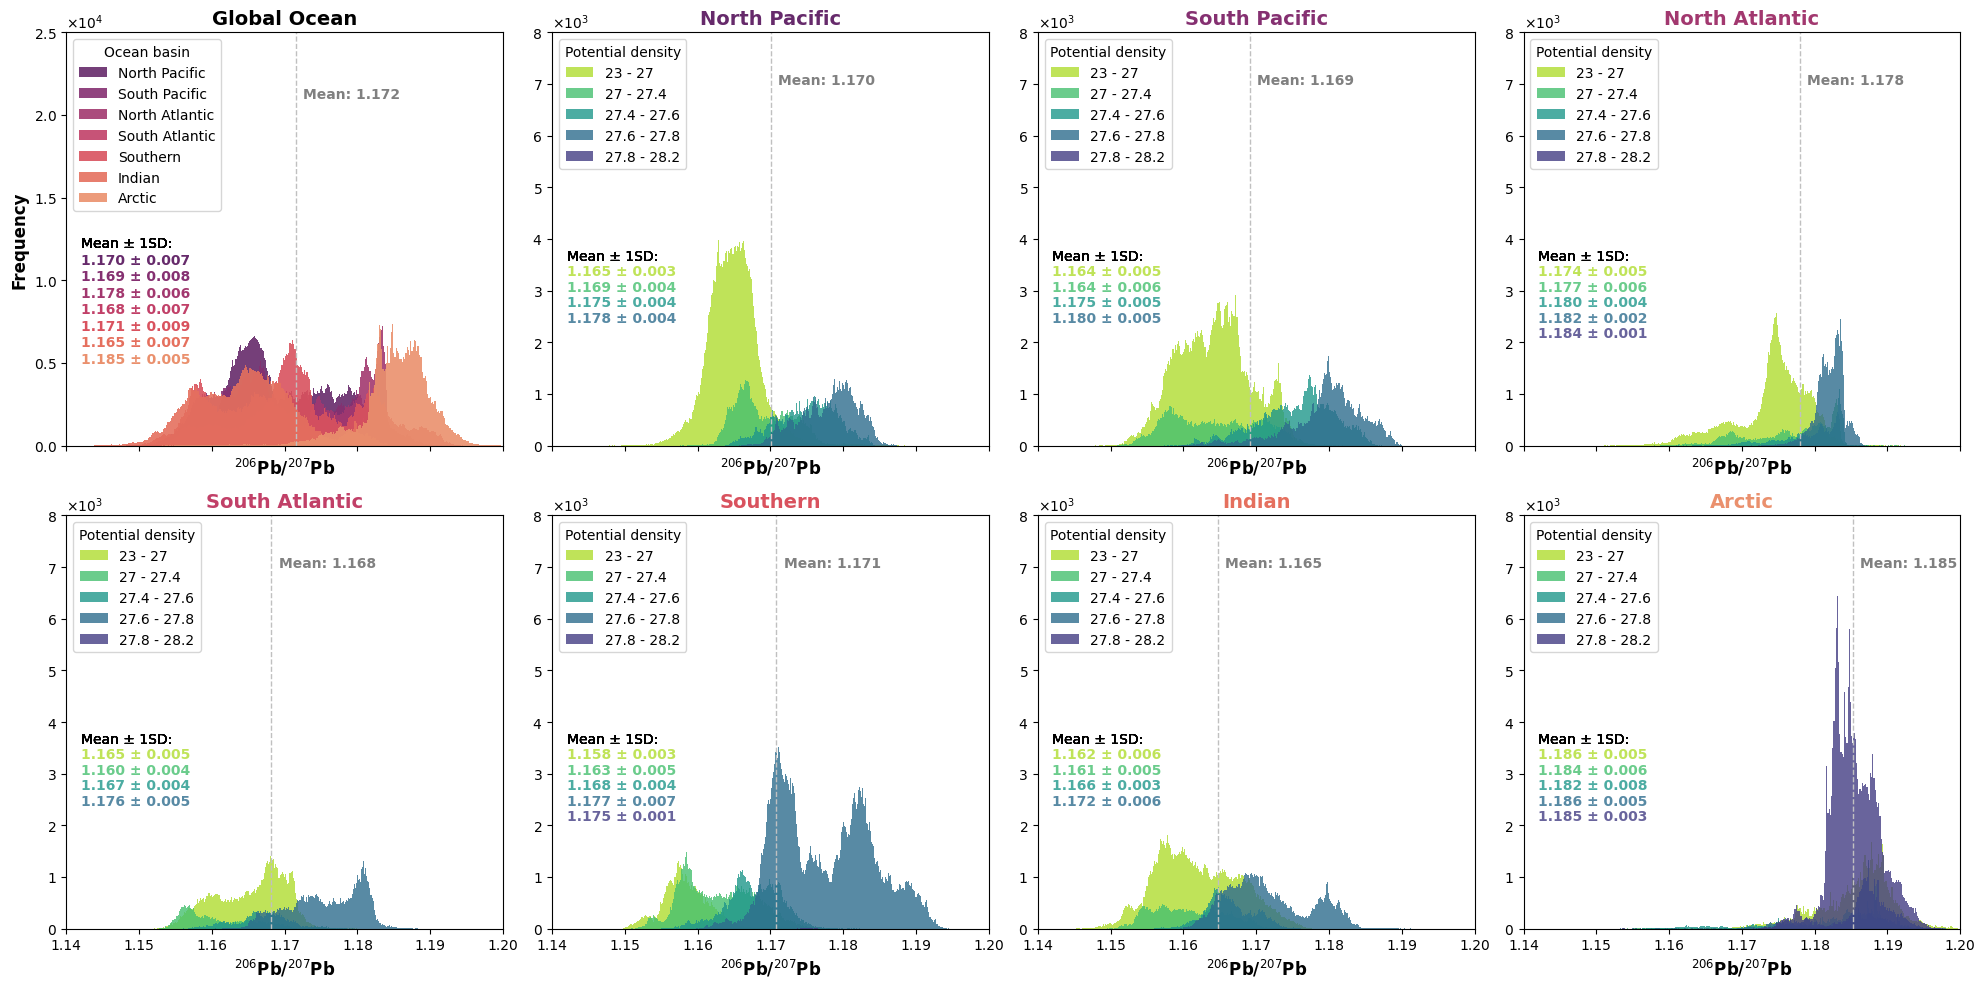

In [38]:
basins = ['North Pacific', 'South Pacific', 'North Atlantic', 'South Atlantic', 'Southern', 'Indian', 'Arctic']
potential_densities = [23, 27, 27.4, 27.6, 27.8, 28.2]
colors = []
basin_colors = []

fig, axes = plt.subplots(2, int((len(basins)+1)/2), sharex=True, figsize=(20,10))

for i in np.linspace(30, 255, len(basins)+1).astype(int):
    basin_colors.append(sns.color_palette('flare_r', 256)[i])

for i in np.linspace(30, 255, len(potential_densities)).astype(int):
    colors.append(sns.color_palette('viridis_r', 256)[i])

for j, ax in enumerate(axes.flat):
    if j == 0:
        for i in np.arange(0, len(basins)):
            basin_df = prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin'] == basins[i]]
            ax.hist(basin_df['Pb_206_207'], bins=300, alpha=0.9, color = basin_colors[i], label=basins[i])
            ax.set_ylabel('Frequency', fontweight='bold', fontsize = 12)
            ax.set_title('Global Ocean', fontweight='bold', fontsize = 14)
            ax.text(1.142, 12000, f'Mean ± 1SD:', color='black', fontsize=10)
            ax.text(1.142, (len(basins)-i)*1000+4000, f'{round(basin_df["Pb_206_207"].mean(), 3):.3f} ± {round(basin_df["Pb_206_207"].std(), 3):.3f}', color=basin_colors[i], fontsize=10, fontweight='bold')
            ax.set_ylim(0, 25000)               
        ax.vlines(prediction_df_latlon_NS['Pb_206_207'].mean(), ymin=0, ymax=26000, color='silver', linestyle='dashed', linewidth=1)
        ax.text(prediction_df_latlon_NS['Pb_206_207'].mean()+0.001, 21000, f'Mean: {round(prediction_df_latlon_NS["Pb_206_207"].mean(), 3):.3f}', color='gray', fontsize=10, fontweight='bold')
        ax.legend(fontsize=10, loc='upper left', title='Ocean basin')

    else:
        for i in np.arange(0, len(potential_densities)-1):
            density_df = prediction_df_latlon_NS[(prediction_df_latlon_NS['potential_density'] >= potential_densities[i]) & (prediction_df_latlon_NS['potential_density'] < potential_densities[i+1]) & (prediction_df_latlon_NS['Ocean_basin'] == basins[j-1])]
            ax.hist(density_df['Pb_206_207'], bins=300, alpha=0.8, color = colors[i], label=f'{potential_densities[i]} - {potential_densities[i+1]}')
            ax.set_title(basins[j-1], fontweight='bold', fontsize = 14, color = basin_colors[j-1])
            ax.text(1.142, 3600, f'Mean ± 1SD:', color='black', fontsize=10, zorder=1)
            if f'{round(density_df["Pb_206_207"].mean(), 3):.3f}' != 'nan':
                ax.text(1.142, (len(basins)-i)*300+1200, f'{round(density_df["Pb_206_207"].mean(), 3):.3f} ± {round(density_df["Pb_206_207"].std(), 3):.3f}', color=colors[i], fontsize=10, fontweight='bold', alpha = 0.8, zorder=1)
            ax.set_ylim(0, 8000)
        #rect = Rectangle((59, 1700), 19, 1600, edgecolor='black', facecolor='black', zorder=0)    
        #ax.add_patch(rect)
        ax.vlines(prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin']==basins[j-1]]['Pb_206_207'].mean(), ymin=0, ymax=26000, color='silver', linestyle='dashed', linewidth=1)
        ax.text(prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin']==basins[j-1]]['Pb_206_207'].mean()+0.001, 7000, f'Mean: {round(prediction_df_latlon_NS[prediction_df_latlon_NS["Ocean_basin"]==basins[j-1]]["Pb_206_207"].mean(), 3):.3f}', color='gray', fontsize=10, fontweight='bold')
        ax.legend(fontsize=10, loc='upper left', title= 'Potential density')
    
    ax.set_xlabel('$^{206}$Pb/$^{207}$Pb', fontweight='bold', fontsize = 12)
    ax.set_xlim(1.14,1.20)
    ax.ticklabel_format(axis='y', scilimits=(0,0), style='sci', useMathText=True)

plt.tight_layout(w_pad=1)

plt.savefig('../../Figures/Pb_67_hist-predictions_no-coords-density_v2.jpg', dpi = 400)

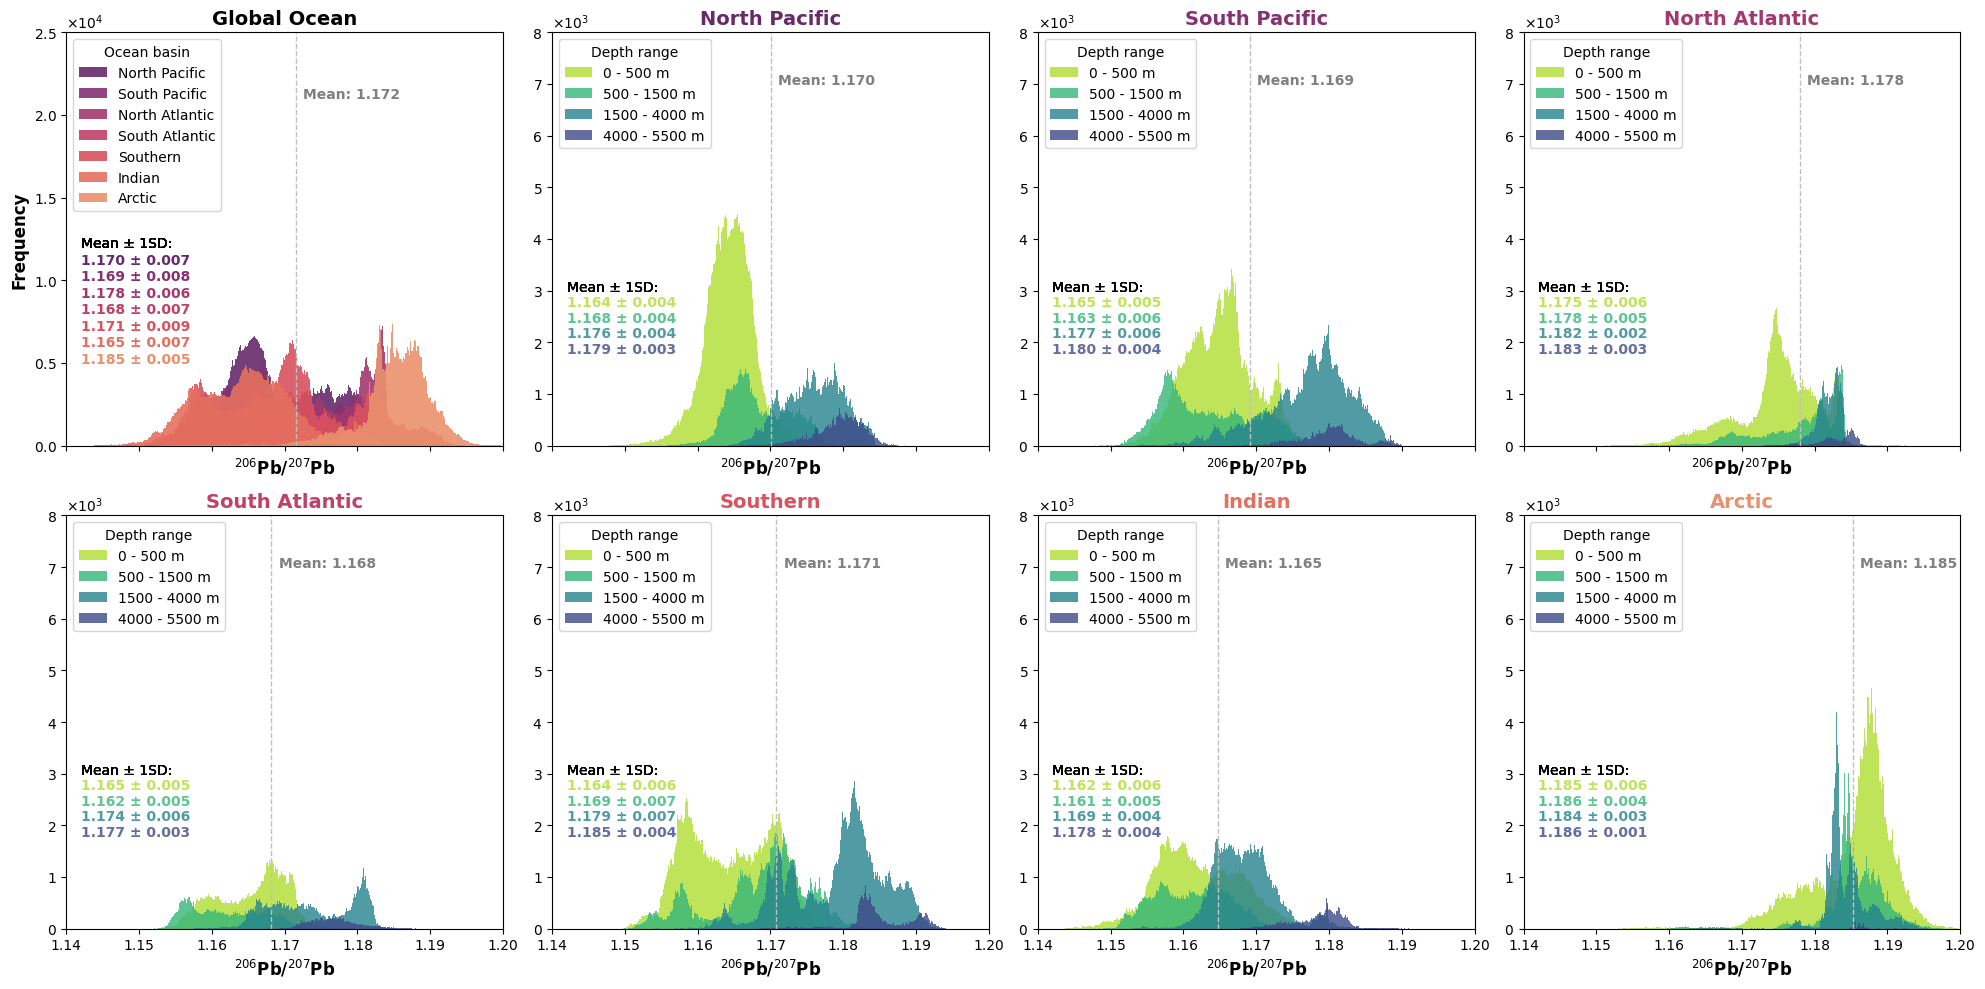

In [39]:
basins = ['North Pacific', 'South Pacific', 'North Atlantic', 'South Atlantic', 'Southern', 'Indian', 'Arctic']
depths = [0, 500, 1500, 4000, 5500]
colors = []
basin_colors = []

fig, axes = plt.subplots(2, int((len(basins)+1)/2), sharex=True, figsize=(20,10))

for i in np.linspace(30, 255, len(basins)+1).astype(int):
    basin_colors.append(sns.color_palette('flare_r', 256)[i])

for i in np.linspace(30, 255, len(depths)).astype(int):
    colors.append(sns.color_palette('viridis_r', 256)[i])

for j, ax in enumerate(axes.flat):
    if j == 0:
        for i in np.arange(0, len(basins)):
            basin_df = prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin'] == basins[i]]
            ax.hist(basin_df['Pb_206_207'], bins=300, alpha=0.9, color = basin_colors[i], label=basins[i])
            ax.set_ylabel('Frequency', fontweight='bold', fontsize = 12)
            ax.set_title('Global Ocean', fontweight='bold', fontsize = 14)
            ax.text(1.142, 12000, f'Mean ± 1SD:', color='black', fontsize=10)
            ax.text(1.142, (len(basins)-i)*1000+4000, f'{round(basin_df["Pb_206_207"].mean(), 3):.3f} ± {round(basin_df["Pb_206_207"].std(), 3):.3f}', color=basin_colors[i], fontsize=10, fontweight='bold')
            ax.set_ylim(0, 25000)               
        ax.vlines(prediction_df_latlon_NS['Pb_206_207'].mean(), ymin=0, ymax=26000, color='silver', linestyle='dashed', linewidth=1)
        ax.text(prediction_df_latlon_NS['Pb_206_207'].mean()+0.001, 21000, f'Mean: {round(prediction_df_latlon_NS["Pb_206_207"].mean(), 3):.3f}', color='gray', fontsize=10, fontweight='bold')
        ax.legend(fontsize=10, loc='upper left', title='Ocean basin')

    else:
        for i in np.arange(0, len(depths)-1):
            depth_df = prediction_df_latlon_NS[(prediction_df_latlon_NS['Depth'] >= depths[i]) & (prediction_df_latlon_NS['Depth'] < depths[i+1]) & (prediction_df_latlon_NS['Ocean_basin'] == basins[j-1])]
            ax.hist(depth_df['Pb_206_207'], bins=300, alpha=0.8, color = colors[i], label=f'{depths[i]} - {depths[i+1]} m')
            ax.set_title(basins[j-1], fontweight='bold', fontsize = 14, color = basin_colors[j-1])
            ax.text(1.142, 3000, f'Mean ± 1SD:', color='black', fontsize=10, zorder=1)
            ax.text(1.142, (len(basins)-i)*300+600, f'{round(depth_df["Pb_206_207"].mean(), 3):.3f} ± {round(depth_df["Pb_206_207"].std(), 3):.3f}', color=colors[i], fontsize=10, fontweight='bold', alpha = 0.8, zorder=1)
            ax.set_ylim(0, 8000)
        ax.vlines(prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin']==basins[j-1]]['Pb_206_207'].mean(), ymin=0, ymax=26000, color='silver', linestyle='dashed', linewidth=1)
        ax.text(prediction_df_latlon_NS[prediction_df_latlon_NS['Ocean_basin']==basins[j-1]]['Pb_206_207'].mean()+0.001, 7000, f'Mean: {round(prediction_df_latlon_NS[prediction_df_latlon_NS["Ocean_basin"]==basins[j-1]]["Pb_206_207"].mean(), 3):.3f}', color='gray', fontsize=10, fontweight='bold')
        ax.legend(fontsize=10, loc='upper left', title='Depth range')
    
    ax.set_xlabel('$^{206}$Pb/$^{207}$Pb', fontweight='bold', fontsize = 12)
    ax.set_xlim(1.14,1.20)
    ax.ticklabel_format(axis='y', scilimits=(0,0), style='sci', useMathText=True)

plt.tight_layout(w_pad=1)

plt.savefig('../../Figures/Pb_67_hist-predictions_no-coords-depth_v2.jpg', dpi = 400)